In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [3]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [4]:
import xgboost
from xgboost import XGBRegressor, XGBClassifier

In [5]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import max_num_bins, Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve


# AUX FUNCTION TO FIND SOLUTIONS

def dx(fn, x, delta=0.001):
    return (fn(x+delta) - fn(x))/delta

def solvecross(fn, value, x=-45.5, maxtries=1000, maxerr=0.00001):
    for tries in range(maxtries):
        err = fn(x) - value
        if abs(err) < maxerr:
            return x
        slope = dx(fn, x)
        x -= err/slope
    raise ValueError('no solution found')

### DATA

In [6]:
mDM = 500

filefolder = '../../data2024/processed/cs1cs2/'

In [7]:
##############
# PARAMETERS #
##############

tot_B = 634.55+2.26+0.01+0.6+5.34

f_ER = 634.55 / tot_B
f_AC = 2.26 / tot_B
f_CNNS = 0.01 / tot_B
f_RN = 0.6 / tot_B
f_WALL = 5.34 / tot_B

f_ER + f_AC + f_CNNS + f_RN + f_WALL

S_cross1045 = 33.24

cross_factor = np.logspace(-47,-44,10) / 1e-45
S_expected = [max(1, round(S_cross1045 * fac)) for fac in cross_factor]


# DISCOVERY: 'discovery', EXCLUSION: 'exclusion'
D_or_E = 'exclusion'

# requested number of pseudo experiments
num_pseudo = 2000

# number of expected background events per ensemble
B_expected = round(tot_B)

print('B_expected: ', B_expected)
print('S_cross1045: ', S_cross1045)
print('S_expected (from cross=1e-47 to 1e-44): ', S_expected)

B_expected:  643
S_cross1045:  33.24
S_expected (from cross=1e-47 to 1e-44):  [1, 1, 2, 3, 7, 15, 33, 72, 154, 332]


In [8]:
###############
# BACKGROUNDS # 
###############

B_cs1_ER = np.loadtxt(filefolder + 'ER_cs1.txt')
B_cs2_ER = np.loadtxt(filefolder + 'ER_cs2.txt')

print('B_cs1_ER.shape: ', B_cs1_ER.shape)
print('B_cs2_ER.shape: ', B_cs2_ER.shape)


B_cs1_AC = np.loadtxt(filefolder + 'AC_cs1.txt')
B_cs2_AC = np.loadtxt(filefolder + 'AC_cs2.txt')

print('\nB_cs1_AC.shape: ', B_cs1_AC.shape)
print('B_cs2_AC.shape: ', B_cs2_AC.shape)


B_cs1_CNNS = np.loadtxt(filefolder + 'CNNS_cs1.txt')
B_cs2_CNNS = np.loadtxt(filefolder + 'CNNS_cs2.txt')

print('\nB_cs1_CNNS.shape: ', B_cs1_CNNS.shape)
print('B_cs2_CNNS.shape: ', B_cs2_CNNS.shape)


B_cs1_RN = np.loadtxt(filefolder + 'RN_cs1.txt')
B_cs2_RN = np.loadtxt(filefolder + 'RN_cs2.txt')

print('\nB_cs1_RN.shape: ', B_cs1_RN.shape)
print('B_cs2_RN.shape: ', B_cs2_RN.shape)


B_cs1_WALL = np.loadtxt(filefolder + 'WALL_cs1.txt')
B_cs2_WALL = np.loadtxt(filefolder + 'WALL_cs2.txt')

print('\nB_cs1_WALL.shape: ', B_cs1_WALL.shape)
print('B_cs2_WALL.shape: ', B_cs2_WALL.shape)


##########
# SIGNAL #
##########

S_cs1 = np.loadtxt(filefolder + 'WIMP_' + str(mDM) + 'GeV_cs1.txt')
S_cs2 = np.loadtxt(filefolder + 'WIMP_' + str(mDM) + 'GeV_cs2.txt')

print('\nS_cs1.shape: ', S_cs1.shape)
print('S_cs2.shape: ', S_cs2.shape)

B_cs1_ER.shape:  (67300,)
B_cs2_ER.shape:  (67300,)

B_cs1_AC.shape:  (5000,)
B_cs2_AC.shape:  (5000,)

B_cs1_CNNS.shape:  (43,)
B_cs2_CNNS.shape:  (43,)

B_cs1_RN.shape:  (4516,)
B_cs2_RN.shape:  (4516,)

B_cs1_WALL.shape:  (5000,)
B_cs2_WALL.shape:  (5000,)

S_cs1.shape:  (35477,)
S_cs2.shape:  (35477,)


In [9]:
# cs1 = [3, 70] PE
# cS2 = [50, 8000] PE

B_cs1_ER_aux = [B_cs1_ER[x] for x in range(len(B_cs1_ER)) if (3 < B_cs1_ER[x] < 70 and 50 < B_cs2_ER[x] < 8000)]
B_cs2_ER = [B_cs2_ER[x] for x in range(len(B_cs1_ER)) if (3 < B_cs1_ER[x] < 70 and 50 < B_cs2_ER[x] < 8000)]
B_cs1_ER = B_cs1_ER_aux

B_cs1_AC_aux = [B_cs1_AC[x] for x in range(len(B_cs1_AC)) if (3 < B_cs1_AC[x] < 70 and 50 < B_cs2_AC[x] < 8000)]
B_cs2_AC = [B_cs2_AC[x] for x in range(len(B_cs1_AC)) if (3 < B_cs1_AC[x] < 70 and 50 < B_cs2_AC[x] < 8000)]
B_cs1_AC = B_cs1_AC_aux

B_cs1_CNNS_aux = [B_cs1_CNNS[x] for x in range(len(B_cs1_CNNS)) if (3 < B_cs1_CNNS[x] < 70 and 50 < B_cs2_CNNS[x] < 8000)]
B_cs2_CNNS = [B_cs2_CNNS[x] for x in range(len(B_cs1_CNNS)) if (3 < B_cs1_CNNS[x] < 70 and 50 < B_cs2_CNNS[x] < 8000)]
B_cs1_CNNS = B_cs1_CNNS_aux

B_cs1_RN_aux = [B_cs1_RN[x] for x in range(len(B_cs1_RN)) if (3 < B_cs1_RN[x] < 70 and 50 < B_cs2_RN[x] < 8000)]
B_cs2_RN = [B_cs2_RN[x] for x in range(len(B_cs1_RN)) if (3 < B_cs1_RN[x] < 70 and 50 < B_cs2_RN[x] < 8000)]
B_cs1_RN = B_cs1_RN_aux

B_cs1_WALL_aux = [B_cs1_WALL[x] for x in range(len(B_cs1_WALL)) if (3 < B_cs1_WALL[x] < 70 and 50 < B_cs2_WALL[x] < 8000)]
B_cs2_WALL = [B_cs2_WALL[x] for x in range(len(B_cs1_WALL)) if (3 < B_cs1_WALL[x] < 70 and 50 < B_cs2_WALL[x] < 8000)]
B_cs1_WALL = B_cs1_WALL_aux


S_cs1_aux = [S_cs1[x] for x in range(len(S_cs1)) if (3 < S_cs1[x] < 70 and 50 < S_cs2[x] < 8000)]
S_cs2 = [S_cs2[x] for x in range(len(S_cs1)) if (3 < S_cs1[x] < 70 and 50 < S_cs2[x] < 8000)]
S_cs1 = S_cs1_aux


##### Select the number of events per class

In [10]:
NUM_DAT = min(len(B_cs1_ER), len(S_cs1))
print(' NUM_DAT: ', NUM_DAT, '\n')

NUM_DAT_AC = int(NUM_DAT*f_AC)
NUM_DAT_CNNS = max(1, int(NUM_DAT*f_CNNS))
NUM_DAT_RN = int(NUM_DAT*f_RN)
NUM_DAT_WALL = int(NUM_DAT*f_WALL)

NUM_DAT_ER = NUM_DAT - ( NUM_DAT_AC + NUM_DAT_CNNS + NUM_DAT_RN + NUM_DAT_WALL )

print('NUM_DAT_ER: ', NUM_DAT_ER)
print('NUM_DAT_AC: ', NUM_DAT_AC)
print('NUM_DAT_CNNS: ', NUM_DAT_CNNS)
print('NUM_DAT_RN: ', NUM_DAT_RN)
print('NUM_DAT_WALL: ', NUM_DAT_WALL)



# CONCATENATE THE BACKGROUNDS
B_cs1cs2 = np.concatenate([np.stack([B_cs1_ER,B_cs2_ER],axis=1)[:NUM_DAT_ER], np.stack([B_cs1_AC,B_cs2_AC],axis=1)[:NUM_DAT_AC], np.stack([B_cs1_CNNS,B_cs2_CNNS],axis=1)[:NUM_DAT_CNNS], np.stack([B_cs1_RN,B_cs2_RN],axis=1)[:NUM_DAT_RN], np.stack([B_cs1_WALL,B_cs2_WALL],axis=1)[:NUM_DAT_WALL]])

print('\nB_cs1cs2.shape: ', B_cs1cs2.shape)


S_cs1cs2 = np.stack([S_cs1,S_cs2],axis=1)[:NUM_DAT]


print('\nS_cs1cs2.shape: ', S_cs1cs2.shape)

 NUM_DAT:  32117 

NUM_DAT_ER:  31709
NUM_DAT_AC:  112
NUM_DAT_CNNS:  1
NUM_DAT_RN:  29
NUM_DAT_WALL:  266

B_cs1cs2.shape:  (32117, 2)

S_cs1cs2.shape:  (32117, 2)


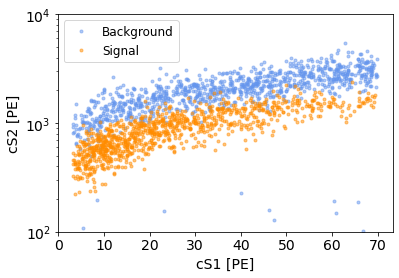

In [24]:
rnd = 100

B_cs1cs2_plot = shuffle(B_cs1cs2, random_state=rnd)
S_cs1cs2_plot = shuffle(S_cs1cs2, random_state=rnd)

plt.plot(B_cs1cs2_plot[:,0][:1000], B_cs1cs2_plot[:,1][:1000], '.', color='cornflowerblue', alpha=0.5, label='Background')
plt.plot(S_cs1cs2_plot[:,0][:1000], S_cs1cs2_plot[:,1][:1000], '.', color='darkorange', alpha=0.5, label='Signal')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel('cS1 [PE]',fontsize=14)
plt.ylabel('cS2 [PE]',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(scatterpoints=5, fontsize=14)
# plt.grid()
plt.legend(loc="upper left", fontsize=12)
plt.savefig('cs1cs2.pdf',bbox_inches='tight')
plt.show()

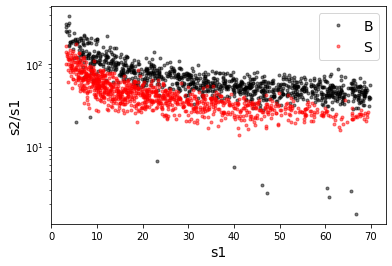

In [11]:
plt.plot(B_cs1cs2_plot[:,0][:1000], (B_cs1cs2_plot[:,1] / B_cs1cs2_plot[:,0])[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_cs1cs2_plot[:,0][:1000], (S_cs1cs2_plot[:,1] / S_cs1cs2_plot[:,0])[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('s1',fontsize=14)
plt.ylabel('s2/s1',fontsize=14)
plt.legend(fontsize=14)
plt.show()

## 1. cS1 and cS2

In [12]:
# concatenate the data
X_mon_B = B_cs1cs2
X_mon_S = S_cs1cs2

# X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))
# X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))
print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (32117, 2)
X_mon_S.shape:  (32117, 2)
X_mon.shape:  (64234, 2)

X_mon_train :  (40948, 2)
y_mon_train :  (40948,)
X_mon_val :  (7227, 2)
y_mon_val :  (7227,)
X_mon_test :  (16059, 2)
y_mon_test :  (16059,)



## CLASSIFIERS

### XGBoost

[0]	validation_0-logloss:0.68563	validation_1-logloss:0.68565
[1]	validation_0-logloss:0.67826	validation_1-logloss:0.67830


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-logloss:0.67102	validation_1-logloss:0.67109
[3]	validation_0-logloss:0.66394	validation_1-logloss:0.66404
[4]	validation_0-logloss:0.65698	validation_1-logloss:0.65711
[5]	validation_0-logloss:0.65015	validation_1-logloss:0.65030
[6]	validation_0-logloss:0.64346	validation_1-logloss:0.64365
[7]	validation_0-logloss:0.63688	validation_1-logloss:0.63709
[8]	validation_0-logloss:0.63044	validation_1-logloss:0.63069
[9]	validation_0-logloss:0.62410	validation_1-logloss:0.62437
[10]	validation_0-logloss:0.61787	validation_1-logloss:0.61818
[11]	validation_0-logloss:0.61179	validation_1-logloss:0.61212
[12]	validation_0-logloss:0.60577	validation_1-logloss:0.60615
[13]	validation_0-logloss:0.59987	validation_1-logloss:0.60028
[14]	validation_0-logloss:0.59409	validation_1-logloss:0.59452
[15]	validation_0-logloss:0.58838	validation_1-logloss:0.58886
[16]	validation_0-logloss:0.58279	validation_1-logloss:0.58330
[17]	validation_0-logloss:0.57731	validation_1-logloss:0.57783


[132]	validation_0-logloss:0.27702	validation_1-logloss:0.27976
[133]	validation_0-logloss:0.27592	validation_1-logloss:0.27866
[134]	validation_0-logloss:0.27481	validation_1-logloss:0.27757
[135]	validation_0-logloss:0.27374	validation_1-logloss:0.27651
[136]	validation_0-logloss:0.27267	validation_1-logloss:0.27545
[137]	validation_0-logloss:0.27162	validation_1-logloss:0.27441
[138]	validation_0-logloss:0.27058	validation_1-logloss:0.27338
[139]	validation_0-logloss:0.26955	validation_1-logloss:0.27236
[140]	validation_0-logloss:0.26854	validation_1-logloss:0.27136
[141]	validation_0-logloss:0.26752	validation_1-logloss:0.27035
[142]	validation_0-logloss:0.26653	validation_1-logloss:0.26937
[143]	validation_0-logloss:0.26554	validation_1-logloss:0.26839
[144]	validation_0-logloss:0.26457	validation_1-logloss:0.26744
[145]	validation_0-logloss:0.26360	validation_1-logloss:0.26649
[146]	validation_0-logloss:0.26266	validation_1-logloss:0.26554
[147]	validation_0-logloss:0.26172	valid

[261]	validation_0-logloss:0.20277	validation_1-logloss:0.20598
[262]	validation_0-logloss:0.20253	validation_1-logloss:0.20574
[263]	validation_0-logloss:0.20228	validation_1-logloss:0.20549
[264]	validation_0-logloss:0.20203	validation_1-logloss:0.20524
[265]	validation_0-logloss:0.20179	validation_1-logloss:0.20499
[266]	validation_0-logloss:0.20156	validation_1-logloss:0.20475
[267]	validation_0-logloss:0.20131	validation_1-logloss:0.20452
[268]	validation_0-logloss:0.20107	validation_1-logloss:0.20428
[269]	validation_0-logloss:0.20084	validation_1-logloss:0.20406
[270]	validation_0-logloss:0.20061	validation_1-logloss:0.20382
[271]	validation_0-logloss:0.20038	validation_1-logloss:0.20359
[272]	validation_0-logloss:0.20016	validation_1-logloss:0.20338
[273]	validation_0-logloss:0.19994	validation_1-logloss:0.20315
[274]	validation_0-logloss:0.19972	validation_1-logloss:0.20292
[275]	validation_0-logloss:0.19950	validation_1-logloss:0.20271
[276]	validation_0-logloss:0.19929	valid

[390]	validation_0-logloss:0.18512	validation_1-logloss:0.18854
[391]	validation_0-logloss:0.18506	validation_1-logloss:0.18848
[392]	validation_0-logloss:0.18499	validation_1-logloss:0.18842
[393]	validation_0-logloss:0.18493	validation_1-logloss:0.18835
[394]	validation_0-logloss:0.18486	validation_1-logloss:0.18829
[395]	validation_0-logloss:0.18480	validation_1-logloss:0.18823
[396]	validation_0-logloss:0.18474	validation_1-logloss:0.18818
[397]	validation_0-logloss:0.18468	validation_1-logloss:0.18812
[398]	validation_0-logloss:0.18462	validation_1-logloss:0.18806
[399]	validation_0-logloss:0.18455	validation_1-logloss:0.18799
[400]	validation_0-logloss:0.18450	validation_1-logloss:0.18794
[401]	validation_0-logloss:0.18444	validation_1-logloss:0.18788
[402]	validation_0-logloss:0.18438	validation_1-logloss:0.18784
[403]	validation_0-logloss:0.18432	validation_1-logloss:0.18778
[404]	validation_0-logloss:0.18426	validation_1-logloss:0.18773
[405]	validation_0-logloss:0.18421	valid

[519]	validation_0-logloss:0.18006	validation_1-logloss:0.18431
[520]	validation_0-logloss:0.18004	validation_1-logloss:0.18430
[521]	validation_0-logloss:0.18003	validation_1-logloss:0.18429
[522]	validation_0-logloss:0.18000	validation_1-logloss:0.18427
[523]	validation_0-logloss:0.17998	validation_1-logloss:0.18425
[524]	validation_0-logloss:0.17996	validation_1-logloss:0.18424
[525]	validation_0-logloss:0.17994	validation_1-logloss:0.18424
[526]	validation_0-logloss:0.17991	validation_1-logloss:0.18422
[527]	validation_0-logloss:0.17989	validation_1-logloss:0.18420
[528]	validation_0-logloss:0.17987	validation_1-logloss:0.18419
[529]	validation_0-logloss:0.17986	validation_1-logloss:0.18418
[530]	validation_0-logloss:0.17984	validation_1-logloss:0.18417
[531]	validation_0-logloss:0.17981	validation_1-logloss:0.18415
[532]	validation_0-logloss:0.17979	validation_1-logloss:0.18415
[533]	validation_0-logloss:0.17978	validation_1-logloss:0.18414
[534]	validation_0-logloss:0.17975	valid

[648]	validation_0-logloss:0.17826	validation_1-logloss:0.18332
[649]	validation_0-logloss:0.17825	validation_1-logloss:0.18332
[650]	validation_0-logloss:0.17824	validation_1-logloss:0.18332
[651]	validation_0-logloss:0.17823	validation_1-logloss:0.18332
[652]	validation_0-logloss:0.17822	validation_1-logloss:0.18330
[653]	validation_0-logloss:0.17822	validation_1-logloss:0.18330
[654]	validation_0-logloss:0.17820	validation_1-logloss:0.18330
[655]	validation_0-logloss:0.17820	validation_1-logloss:0.18330
[656]	validation_0-logloss:0.17818	validation_1-logloss:0.18329
[657]	validation_0-logloss:0.17817	validation_1-logloss:0.18330
[658]	validation_0-logloss:0.17816	validation_1-logloss:0.18330
[659]	validation_0-logloss:0.17815	validation_1-logloss:0.18329
[660]	validation_0-logloss:0.17814	validation_1-logloss:0.18329
[661]	validation_0-logloss:0.17813	validation_1-logloss:0.18328
[662]	validation_0-logloss:0.17812	validation_1-logloss:0.18328
[663]	validation_0-logloss:0.17811	valid

[777]	validation_0-logloss:0.17696	validation_1-logloss:0.18308
[778]	validation_0-logloss:0.17695	validation_1-logloss:0.18308
[779]	validation_0-logloss:0.17694	validation_1-logloss:0.18308
[780]	validation_0-logloss:0.17693	validation_1-logloss:0.18307
[781]	validation_0-logloss:0.17692	validation_1-logloss:0.18307
[782]	validation_0-logloss:0.17692	validation_1-logloss:0.18307
[783]	validation_0-logloss:0.17690	validation_1-logloss:0.18307
[784]	validation_0-logloss:0.17689	validation_1-logloss:0.18307
[785]	validation_0-logloss:0.17688	validation_1-logloss:0.18307
[786]	validation_0-logloss:0.17687	validation_1-logloss:0.18306
[787]	validation_0-logloss:0.17686	validation_1-logloss:0.18306
[788]	validation_0-logloss:0.17686	validation_1-logloss:0.18306
[789]	validation_0-logloss:0.17684	validation_1-logloss:0.18305
[790]	validation_0-logloss:0.17683	validation_1-logloss:0.18305
[791]	validation_0-logloss:0.17681	validation_1-logloss:0.18306
[792]	validation_0-logloss:0.17680	valid

[906]	validation_0-logloss:0.17558	validation_1-logloss:0.18291
[907]	validation_0-logloss:0.17557	validation_1-logloss:0.18291
[908]	validation_0-logloss:0.17556	validation_1-logloss:0.18291
[909]	validation_0-logloss:0.17555	validation_1-logloss:0.18291
[910]	validation_0-logloss:0.17553	validation_1-logloss:0.18291
[911]	validation_0-logloss:0.17552	validation_1-logloss:0.18291
[912]	validation_0-logloss:0.17552	validation_1-logloss:0.18290
[913]	validation_0-logloss:0.17551	validation_1-logloss:0.18290
[914]	validation_0-logloss:0.17550	validation_1-logloss:0.18290
[915]	validation_0-logloss:0.17550	validation_1-logloss:0.18290
[916]	validation_0-logloss:0.17548	validation_1-logloss:0.18289
[917]	validation_0-logloss:0.17546	validation_1-logloss:0.18290
[918]	validation_0-logloss:0.17545	validation_1-logloss:0.18290
[919]	validation_0-logloss:0.17544	validation_1-logloss:0.18290
[920]	validation_0-logloss:0.17544	validation_1-logloss:0.18290
[921]	validation_0-logloss:0.17542	valid

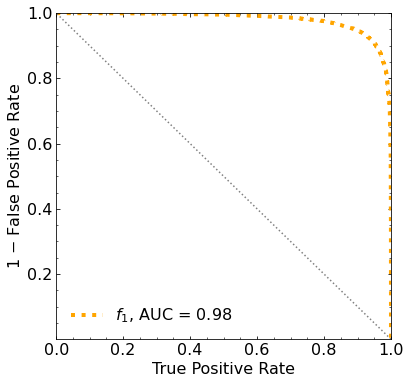

Classification score:


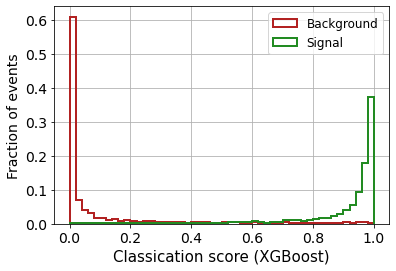


 ROC-AUC =  0.9798855396469355


In [13]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=2500,
    learning_rate=0.01,
    reg_lambda=0.01,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [15]:
np.savetxt('rocs/roc_cs1cs2.txt', [tpr_mon_xg, fpr_mon_xg])

print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9798855396469355


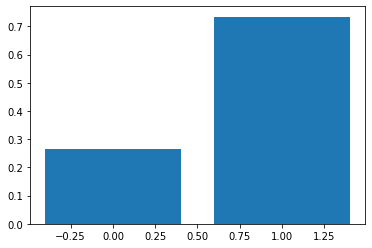

In [14]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

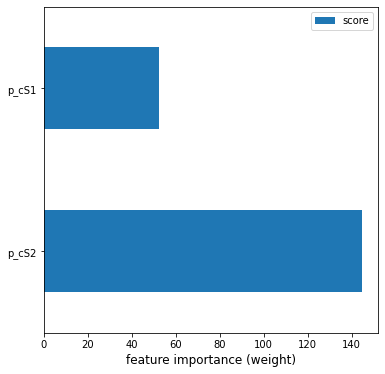

In [15]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
keys = ['p_cS1','p_cS2']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 40 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

In [16]:
keys

['p_cS1', 'p_cS2']

In [17]:

from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(classifier, X_mon_test, y_mon_test)


In [18]:


sorted_idx = classifier.feature_importances_.argsort()

sorted_idx_keys = []
for i in sorted_idx:
    sorted_idx_keys.append(keys[i])
    
sorted_idx_keys

['p_cS1', 'p_cS2']

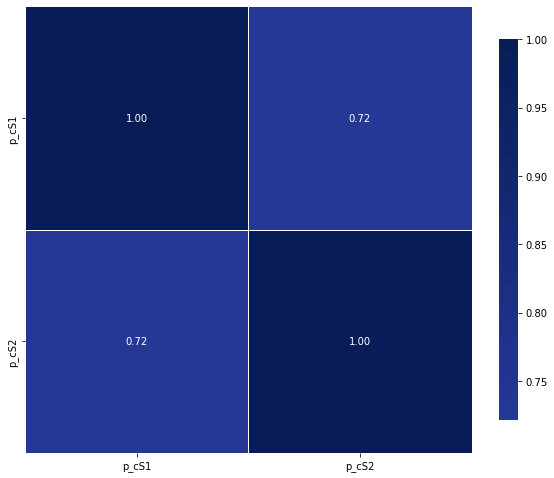

In [19]:
X = pd.DataFrame(X_mon_test, columns=keys)

def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(X[sorted_idx_keys])


In [20]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, B_expected, range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  15 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  15
range of our data:  [[0, 1]]


In [21]:
num_bins = 10

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.097


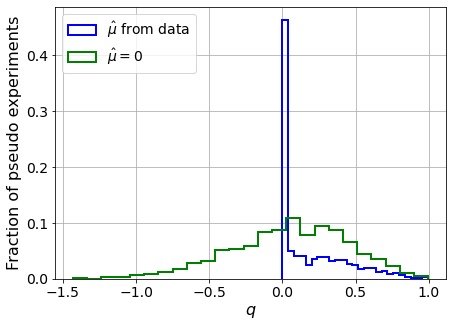

muhat mean:  0.010218735969138037
Z_bins:  0.2654834604236562
std Z_bins:  0.4367225336900901
Z_bins mu=0:  0.2654834604236562
std Z_bins mu=0:  0.7587834096653472

--------

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.094


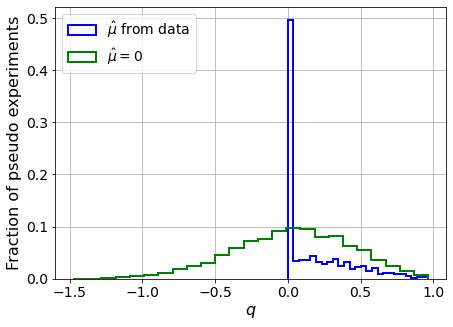

muhat mean:  0.2249671086502931
Z_bins:  0.2113446280556309
std Z_bins:  0.5413701258135654
Z_bins mu=0:  0.2112817353118435
std Z_bins mu=0:  0.9532717813016156

--------

B_expected:  643
S_expected:  2

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0955


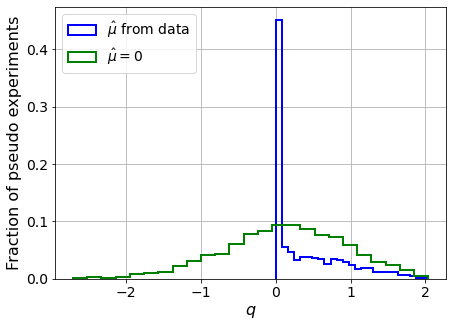

muhat mean:  0.17721187589045634
Z_bins:  0.388617351323076
std Z_bins:  0.6279433637821591
Z_bins mu=0:  0.38733450003110265
std Z_bins mu=0:  1.0576001022825625

--------

B_expected:  643
S_expected:  3

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.093


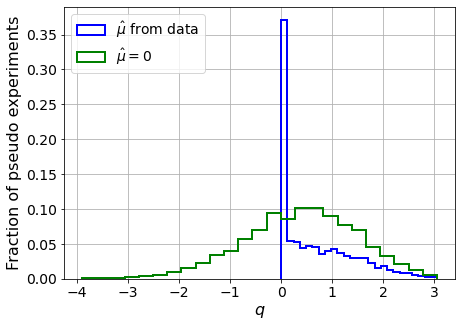

muhat mean:  0.02802220521495904
Z_bins:  0.6462377798332831
std Z_bins:  0.5604886905400638
Z_bins mu=0:  0.6462377798332831
std Z_bins mu=0:  0.8543383910335123

--------

B_expected:  643
S_expected:  7

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.1055


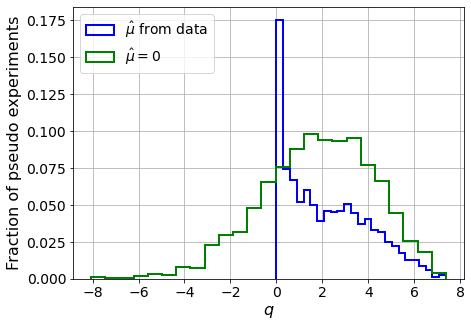

muhat mean:  0.02229249973542325
Z_bins:  1.3855708082443743
std Z_bins:  0.6492480800668367
Z_bins mu=0:  1.3855708082443743
std Z_bins mu=0:  0.8762094371416086

--------

B_expected:  643
S_expected:  15

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0985


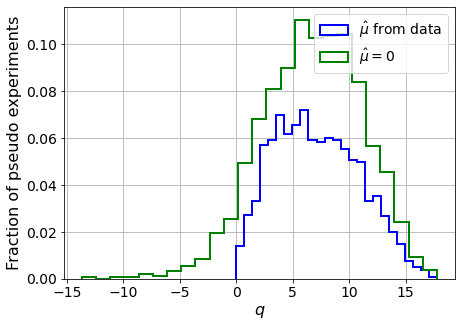

muhat mean:  0.017273018297859533
Z_bins:  2.6264509510886547
std Z_bins:  0.7030497314525752
Z_bins mu=0:  2.626094085591292
std Z_bins mu=0:  0.8374187707389772

--------

B_expected:  643
S_expected:  33

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.092


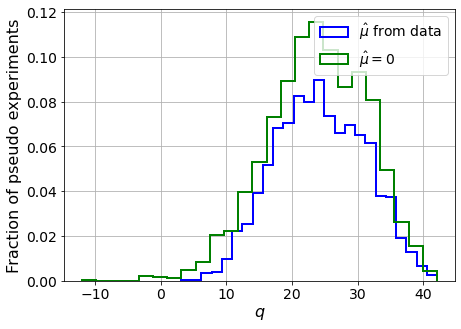

muhat mean:  0.002452566536680865
Z_bins:  4.91318620019116
std Z_bins:  0.6964855906897195
Z_bins mu=0:  4.91318620019116
std Z_bins mu=0:  0.7686202280180796

--------

B_expected:  643
S_expected:  72

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0995


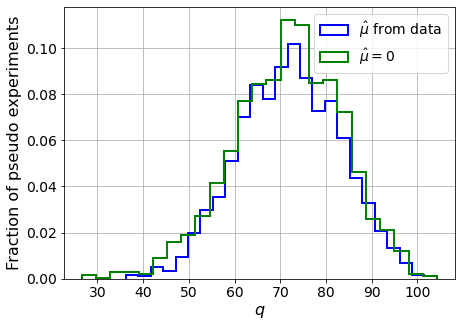

muhat mean:  0.0035235514065425134
Z_bins:  8.49409011523265
std Z_bins:  0.6515560870015534
Z_bins mu=0:  8.493719222412494
std Z_bins mu=0:  0.6971601956038964

--------

B_expected:  643
S_expected:  154

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0995


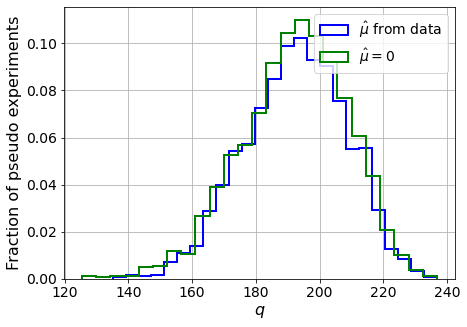

muhat mean:  0.00022335873823731074
Z_bins:  13.900809273890582
std Z_bins:  0.5720628600478551
Z_bins mu=0:  13.898723945160429
std Z_bins mu=0:  0.5982841292035739

--------

B_expected:  643
S_expected:  332

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.084


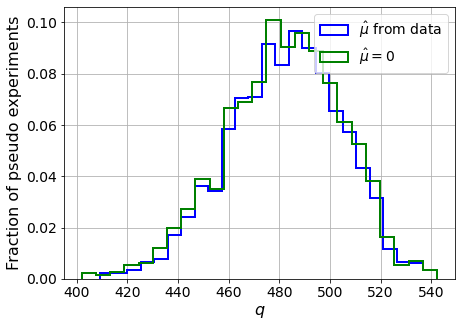

muhat mean:  0.0007842333190899443
Z_bins:  21.982488195536185
std Z_bins:  0.5080063667058893
Z_bins mu=0:  21.982300182143103
std Z_bins mu=0:  0.5249236316649184

--------


 FINAL RESULT:

[[0.2654834604236562, 0.4367225336900901, 0.010218735969138037, 0.2654834604236562, 0.7587834096653472], [0.2113446280556309, 0.5413701258135654, 0.2249671086502931, 0.2112817353118435, 0.9532717813016156], [0.388617351323076, 0.6279433637821591, 0.17721187589045634, 0.38733450003110265, 1.0576001022825625], [0.6462377798332831, 0.5604886905400638, 0.02802220521495904, 0.6462377798332831, 0.8543383910335123], [1.3855708082443743, 0.6492480800668367, 0.02229249973542325, 1.3855708082443743, 0.8762094371416086], [2.6264509510886547, 0.7030497314525752, 0.017273018297859533, 2.626094085591292, 0.8374187707389772], [4.91318620019116, 0.6964855906897195, 0.002452566536680865, 4.91318620019116, 0.7686202280180796], [8.49409011523265, 0.6515560870015534, 0.0035235514065425134, 8.493719222412494, 0.69716

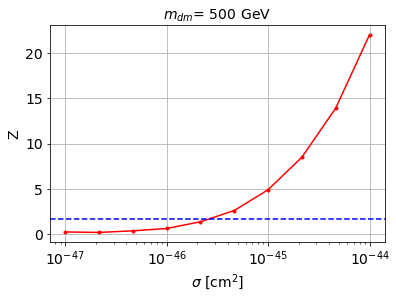


cross_BL_164:  2.521620726768489e-46
cross_BL_164_up:  1.4941915294034923e-46
cross_BL_164_down:  3.864445617210023e-46


In [22]:
# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []


for s_it in range(len(S_expected)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[s_it])
    print('')

    Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, S_expected[s_it], num_pseudo, num_bins, range_dat, MIN_EVS, linear_bins=True) 
    
    store_Z_BL.append( list(Z_BL) )
    
    print('muhat mean: ', Z_BL[2])
    print('Z_bins: ', Z_BL[0])
    print('std Z_bins: ', Z_BL[1])
    print('Z_bins mu=0: ', Z_BL[3])
    print('std Z_bins mu=0: ', Z_BL[4])
    print('')
    print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)


# plot
plt.plot(cross_factor*1e-45, np.array(store_Z_BL)[:,0], '.-', c='red')

plt.axhline(y=1.64, c='blue', linestyle='--')
plt.title('$m_{dm}$= %0.2d GeV' % mDM, fontsize=14)
plt.xscale('log')
plt.xlabel(r'$\sigma$ [cm$^2$]', fontsize=14)
plt.ylabel(r'Z', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()


# interpolate
f_Z = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0], kind='linear')
f_Z_up = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] + np.array(store_Z_BL)[:,1], kind='linear')
f_Z_down = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] - np.array(store_Z_BL)[:,1], kind='linear')

# compute the cross section with Z=1.64
cross_BL_164 = 10**solvecross(f_Z, 1.64)
cross_BL_164_up = 10**solvecross(f_Z_up, 1.64)
cross_BL_164_down = 10**solvecross(f_Z_down, 1.64)

print('\ncross_BL_164: ', cross_BL_164)
print('cross_BL_164_up: ', cross_BL_164_up)
print('cross_BL_164_down: ', cross_BL_164_down)

### DNN

lots of tests, the best is:

Dense layers: 1-4-8-16-32-64-128, 

Activation: LeakyReLu

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 24        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8)                 0         
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5

Epoch 106/500
320/320 [==============================] - 0s 1ms/step - loss: 0.2643 - accuracy: 0.8979 - val_loss: 0.2509 - val_accuracy: 0.8876
Epoch 107/500
320/320 [==============================] - 1s 2ms/step - loss: 0.2707 - accuracy: 0.8943 - val_loss: 0.2437 - val_accuracy: 0.8948
Epoch 108/500
320/320 [==============================] - 1s 2ms/step - loss: 0.2634 - accuracy: 0.8976 - val_loss: 0.2377 - val_accuracy: 0.9001
Epoch 109/500
320/320 [==============================] - 1s 2ms/step - loss: 0.2648 - accuracy: 0.8961 - val_loss: 0.2441 - val_accuracy: 0.8930
Epoch 110/500
320/320 [==============================] - 0s 1ms/step - loss: 0.2658 - accuracy: 0.8948 - val_loss: 0.2720 - val_accuracy: 0.8764
Epoch 111/500
320/320 [==============================] - 1s 2ms/step - loss: 0.2632 - accuracy: 0.8974 - val_loss: 0.2367 - val_accuracy: 0.9015
Epoch 112/500
320/320 [==============================] - 1s 3ms/step - loss: 0.2695 - accuracy: 0.8939 - val_loss: 0.2248 - val_ac

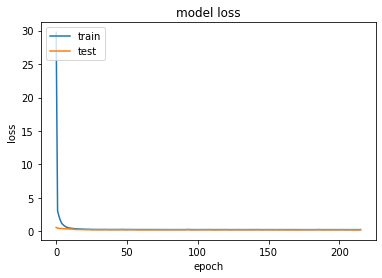

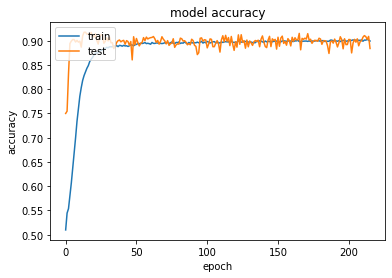

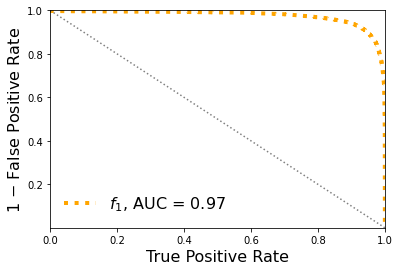

Classification score:


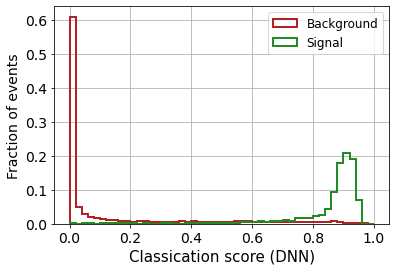


 ROC-AUC =  0.9746851546907163


In [24]:

# define the keras model
model = Sequential()
model.add(Dense(8, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [25]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9746851546907163


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                48        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 68        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

Epoch 106/500
320/320 [==============================] - 0s 1ms/step - loss: 0.2313 - accuracy: 0.9094 - val_loss: 0.1951 - val_accuracy: 0.9227
Epoch 107/500
320/320 [==============================] - 1s 2ms/step - loss: 0.2272 - accuracy: 0.9105 - val_loss: 0.1960 - val_accuracy: 0.9213
Epoch 108/500
320/320 [==============================] - 0s 1ms/step - loss: 0.2307 - accuracy: 0.9083 - val_loss: 0.2020 - val_accuracy: 0.9228
Epoch 109/500
320/320 [==============================] - 1s 2ms/step - loss: 0.2339 - accuracy: 0.9099 - val_loss: 0.1940 - val_accuracy: 0.9224
Epoch 110/500
320/320 [==============================] - 0s 1ms/step - loss: 0.2314 - accuracy: 0.9105 - val_loss: 0.1963 - val_accuracy: 0.9200
Epoch 111/500
320/320 [==============================] - 0s 1ms/step - loss: 0.2240 - accuracy: 0.9116 - val_loss: 0.2005 - val_accuracy: 0.9221
Epoch 112/500
320/320 [==============================] - 0s 1ms/step - loss: 0.2296 - accuracy: 0.9098 - val_loss: 0.1927 - val_ac

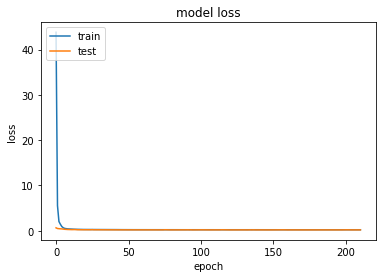

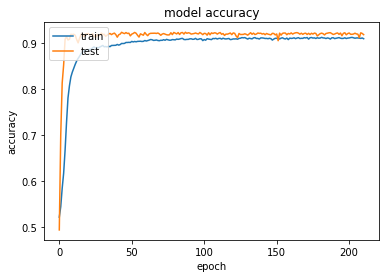

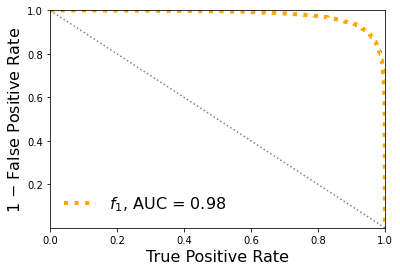

Classification score:


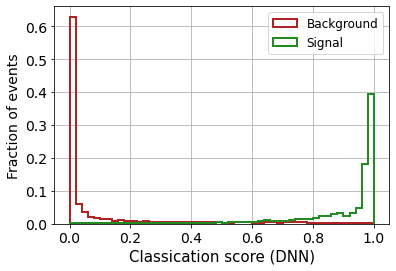


 ROC-AUC =  0.9786746874254894


In [26]:

# define the keras model
model = Sequential()
model.add(Dense(16, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [27]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9786746874254894


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                96        
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                

Epoch 100/500
320/320 [==============================] - 0s 2ms/step - loss: 0.2317 - accuracy: 0.9108 - val_loss: 0.2243 - val_accuracy: 0.9040
Epoch 101/500
320/320 [==============================] - 0s 775us/step - loss: 0.2323 - accuracy: 0.9069 - val_loss: 0.1991 - val_accuracy: 0.9171
Epoch 102/500
320/320 [==============================] - 0s 675us/step - loss: 0.2320 - accuracy: 0.9114 - val_loss: 0.2047 - val_accuracy: 0.9145
Epoch 103/500
320/320 [==============================] - 0s 629us/step - loss: 0.2304 - accuracy: 0.9110 - val_loss: 0.1980 - val_accuracy: 0.9175
Epoch 104/500
320/320 [==============================] - 0s 636us/step - loss: 0.2302 - accuracy: 0.9102 - val_loss: 0.2059 - val_accuracy: 0.9142
Epoch 105/500
320/320 [==============================] - 0s 629us/step - loss: 0.2345 - accuracy: 0.9080 - val_loss: 0.2076 - val_accuracy: 0.9113
Epoch 106/500
320/320 [==============================] - 0s 625us/step - loss: 0.2326 - accuracy: 0.9088 - val_loss: 0.1

Epoch 156/500
320/320 [==============================] - 0s 613us/step - loss: 0.2330 - accuracy: 0.9089 - val_loss: 0.2338 - val_accuracy: 0.8961
Epoch 157/500
320/320 [==============================] - 0s 608us/step - loss: 0.2338 - accuracy: 0.9085 - val_loss: 0.2056 - val_accuracy: 0.9126
Epoch 158/500
320/320 [==============================] - 0s 599us/step - loss: 0.2255 - accuracy: 0.9148 - val_loss: 0.2043 - val_accuracy: 0.9128
Epoch 159/500
320/320 [==============================] - 0s 604us/step - loss: 0.2308 - accuracy: 0.9111 - val_loss: 0.2053 - val_accuracy: 0.9128
Epoch 160/500
320/320 [==============================] - 0s 606us/step - loss: 0.2293 - accuracy: 0.9121 - val_loss: 0.1983 - val_accuracy: 0.9171
Epoch 161/500
320/320 [==============================] - 0s 670us/step - loss: 0.2338 - accuracy: 0.9079 - val_loss: 0.1930 - val_accuracy: 0.9210
Epoch 162/500
320/320 [==============================] - 0s 616us/step - loss: 0.2331 - accuracy: 0.9084 - val_loss: 0

Epoch 212/500
320/320 [==============================] - 0s 623us/step - loss: 0.2296 - accuracy: 0.9102 - val_loss: 0.1879 - val_accuracy: 0.9254
Epoch 213/500
320/320 [==============================] - 0s 603us/step - loss: 0.2239 - accuracy: 0.9141 - val_loss: 0.2015 - val_accuracy: 0.9132
Epoch 214/500
320/320 [==============================] - 0s 623us/step - loss: 0.2263 - accuracy: 0.9127 - val_loss: 0.2171 - val_accuracy: 0.9055
Epoch 215/500
320/320 [==============================] - 0s 620us/step - loss: 0.2291 - accuracy: 0.9094 - val_loss: 0.1902 - val_accuracy: 0.9224
Epoch 216/500
320/320 [==============================] - 0s 617us/step - loss: 0.2255 - accuracy: 0.9115 - val_loss: 0.2003 - val_accuracy: 0.9164
Epoch 217/500
320/320 [==============================] - 0s 622us/step - loss: 0.2353 - accuracy: 0.9098 - val_loss: 0.1962 - val_accuracy: 0.9199
Epoch 218/500
320/320 [==============================] - 0s 630us/step - loss: 0.2268 - accuracy: 0.9109 - val_loss: 0

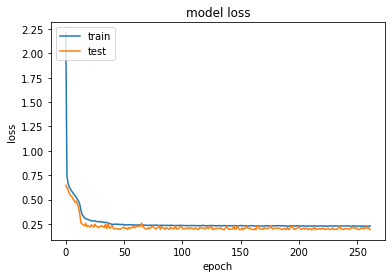

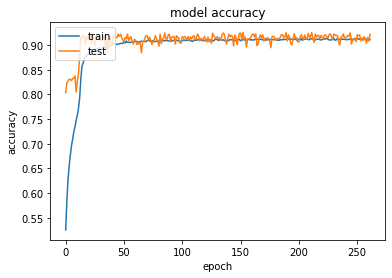

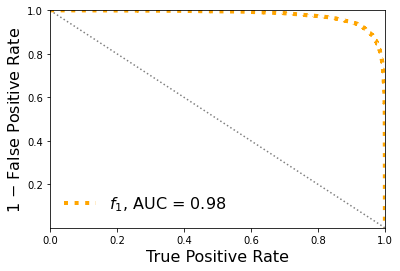

Classification score:


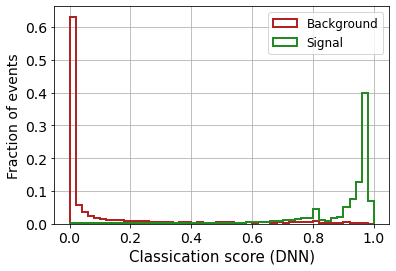


 ROC-AUC =  0.9797172849412481


In [28]:

# define the keras model
model = Sequential()
model.add(Dense(32, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [29]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9797172849412481


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 64)                192       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)               

Epoch 97/500
320/320 [==============================] - 1s 3ms/step - loss: 0.2186 - accuracy: 0.9176 - val_loss: 0.1896 - val_accuracy: 0.9207
Epoch 98/500
320/320 [==============================] - 1s 3ms/step - loss: 0.2194 - accuracy: 0.9160 - val_loss: 0.1898 - val_accuracy: 0.9196
Epoch 99/500
320/320 [==============================] - 1s 3ms/step - loss: 0.2174 - accuracy: 0.9185 - val_loss: 0.2022 - val_accuracy: 0.9160
Epoch 100/500
320/320 [==============================] - 1s 3ms/step - loss: 0.2230 - accuracy: 0.9145 - val_loss: 0.2037 - val_accuracy: 0.9156
Epoch 101/500
320/320 [==============================] - 1s 3ms/step - loss: 0.2155 - accuracy: 0.9172 - val_loss: 0.1986 - val_accuracy: 0.9137
Epoch 102/500
320/320 [==============================] - 1s 3ms/step - loss: 0.2171 - accuracy: 0.9168 - val_loss: 0.1874 - val_accuracy: 0.9233
Epoch 103/500
320/320 [==============================] - 1s 3ms/step - loss: 0.2230 - accuracy: 0.9147 - val_loss: 0.1905 - val_accur

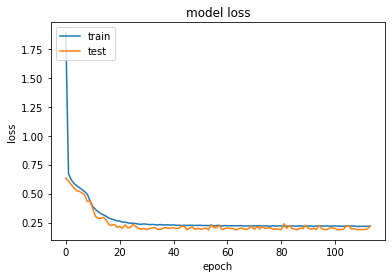

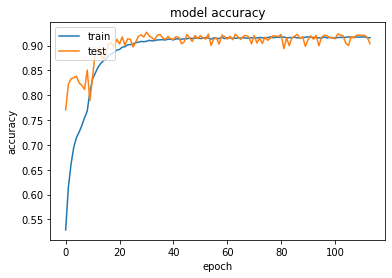

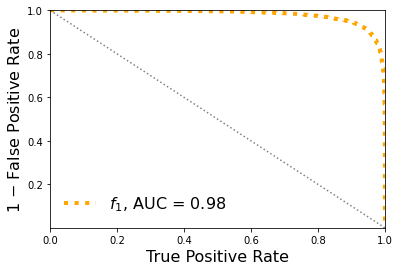

Classification score:


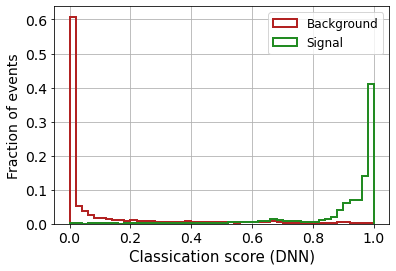


 ROC-AUC =  0.9799874929246938


In [30]:

# define the keras model
model = Sequential()
model.add(Dense(64, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [31]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9799874929246938


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               384       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)               

320/320 [==============================] - 1s 4ms/step - loss: 0.2433 - accuracy: 0.9032 - val_loss: 0.1889 - val_accuracy: 0.9236
Epoch 39/500
320/320 [==============================] - 1s 4ms/step - loss: 0.2448 - accuracy: 0.9003 - val_loss: 0.1965 - val_accuracy: 0.9193
Epoch 40/500
320/320 [==============================] - 1s 4ms/step - loss: 0.2431 - accuracy: 0.9053 - val_loss: 0.1951 - val_accuracy: 0.9214
Epoch 41/500
320/320 [==============================] - 1s 4ms/step - loss: 0.2384 - accuracy: 0.9070 - val_loss: 0.1913 - val_accuracy: 0.9235
Epoch 42/500
320/320 [==============================] - 1s 4ms/step - loss: 0.2267 - accuracy: 0.9111 - val_loss: 0.1955 - val_accuracy: 0.9168
Epoch 43/500
320/320 [==============================] - 1s 4ms/step - loss: 0.2293 - accuracy: 0.9094 - val_loss: 0.1869 - val_accuracy: 0.9267
Epoch 44/500
320/320 [==============================] - 1s 4ms/step - loss: 0.2340 - accuracy: 0.9105 - val_loss: 0.1892 - val_accuracy: 0.9260
Epoch

Epoch 95/500
320/320 [==============================] - 1s 4ms/step - loss: 0.2164 - accuracy: 0.9171 - val_loss: 0.1880 - val_accuracy: 0.9218
Epoch 96/500
320/320 [==============================] - 1s 4ms/step - loss: 0.2180 - accuracy: 0.9179 - val_loss: 0.1995 - val_accuracy: 0.9184
Epoch 97/500
320/320 [==============================] - 1s 4ms/step - loss: 0.2175 - accuracy: 0.9192 - val_loss: 0.1853 - val_accuracy: 0.9269
Epoch 98/500
320/320 [==============================] - 1s 4ms/step - loss: 0.2148 - accuracy: 0.9181 - val_loss: 0.1858 - val_accuracy: 0.9253
Epoch 99/500
320/320 [==============================] - 1s 4ms/step - loss: 0.2169 - accuracy: 0.9196 - val_loss: 0.1862 - val_accuracy: 0.9258
Epoch 100/500
320/320 [==============================] - 1s 4ms/step - loss: 0.2187 - accuracy: 0.9198 - val_loss: 0.1889 - val_accuracy: 0.9233
Epoch 101/500
320/320 [==============================] - 1s 4ms/step - loss: 0.2144 - accuracy: 0.9186 - val_loss: 0.1865 - val_accurac

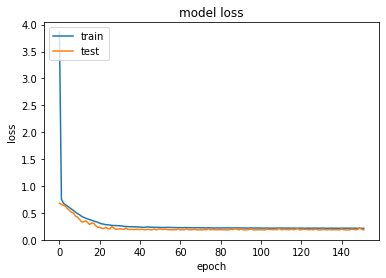

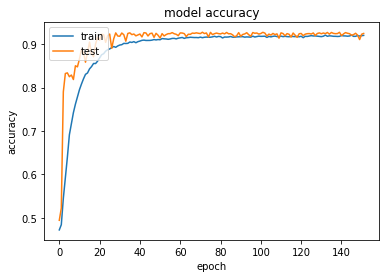

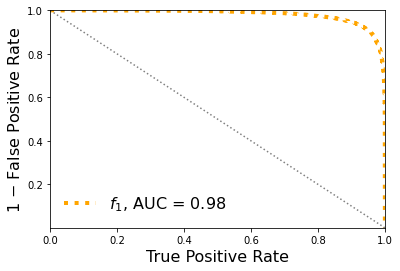

Classification score:


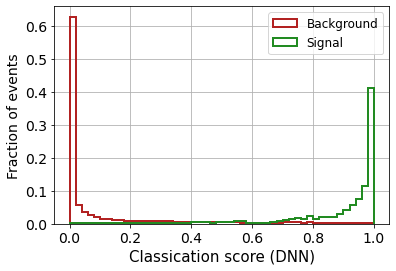


 ROC-AUC =  0.9803201013396659


In [32]:

# define the keras model
model = Sequential()
model.add(Dense(128, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [33]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9803201013396659


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 256)               768       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)               

Epoch 92/500
320/320 [==============================] - 2s 5ms/step - loss: 0.2197 - accuracy: 0.9164 - val_loss: 0.1922 - val_accuracy: 0.9164
Epoch 93/500
320/320 [==============================] - 2s 6ms/step - loss: 0.2236 - accuracy: 0.9128 - val_loss: 0.1897 - val_accuracy: 0.9215
Epoch 94/500
320/320 [==============================] - 4s 11ms/step - loss: 0.2221 - accuracy: 0.9168 - val_loss: 0.1903 - val_accuracy: 0.9209
Epoch 95/500
320/320 [==============================] - 3s 10ms/step - loss: 0.2222 - accuracy: 0.9152 - val_loss: 0.1892 - val_accuracy: 0.9217
Epoch 96/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2247 - accuracy: 0.9132 - val_loss: 0.1893 - val_accuracy: 0.9189
Epoch 97/500
320/320 [==============================] - 2s 7ms/step - loss: 0.2171 - accuracy: 0.9169 - val_loss: 0.1898 - val_accuracy: 0.9257
Epoch 98/500
320/320 [==============================] - 2s 6ms/step - loss: 0.2200 - accuracy: 0.9148 - val_loss: 0.1931 - val_accurac

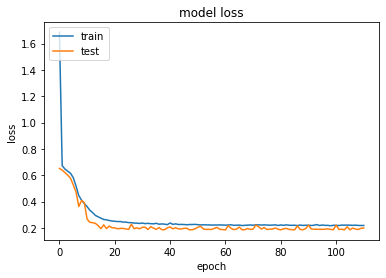

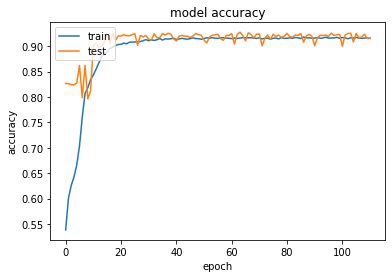

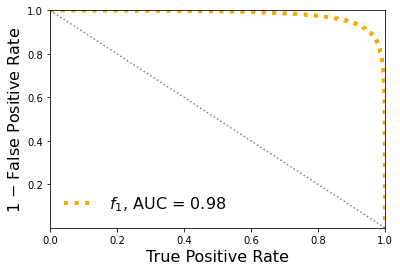

Classification score:


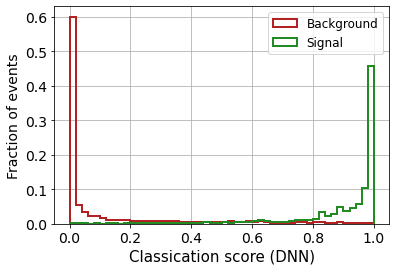


 ROC-AUC =  0.9801077335772395


In [34]:

# define the keras model
model = Sequential()
model.add(Dense(256, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(128))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [35]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9801077335772395


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 256)               768       
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)               

Epoch 92/500
320/320 [==============================] - 2s 6ms/step - loss: 0.2159 - accuracy: 0.9163 - val_loss: 0.2046 - val_accuracy: 0.9167
Epoch 93/500
320/320 [==============================] - 3s 8ms/step - loss: 0.2121 - accuracy: 0.9208 - val_loss: 0.2040 - val_accuracy: 0.9175
Epoch 94/500
320/320 [==============================] - 2s 7ms/step - loss: 0.2179 - accuracy: 0.9176 - val_loss: 0.1907 - val_accuracy: 0.9210
Epoch 95/500
320/320 [==============================] - 2s 7ms/step - loss: 0.2189 - accuracy: 0.9168 - val_loss: 0.2128 - val_accuracy: 0.9112
Epoch 96/500
320/320 [==============================] - 2s 6ms/step - loss: 0.2181 - accuracy: 0.9174 - val_loss: 0.2159 - val_accuracy: 0.9126
Epoch 97/500
320/320 [==============================] - 2s 6ms/step - loss: 0.2159 - accuracy: 0.9180 - val_loss: 0.2249 - val_accuracy: 0.9080
Epoch 98/500
320/320 [==============================] - 2s 7ms/step - loss: 0.2155 - accuracy: 0.9190 - val_loss: 0.1978 - val_accuracy:

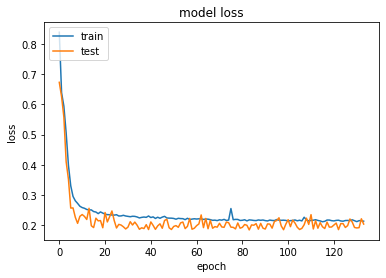

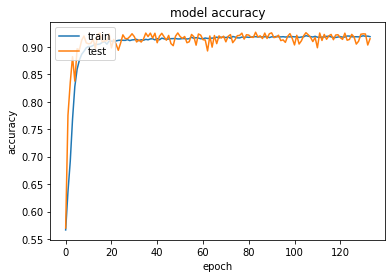

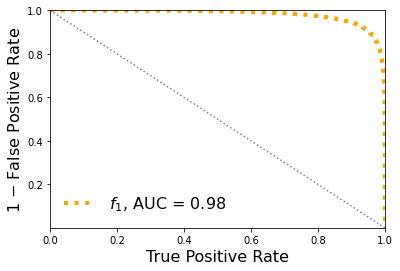

Classification score:


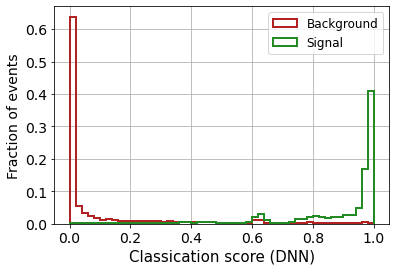


 ROC-AUC =  0.9799806370980135


In [36]:

# define the keras model
model = Sequential()
model.add(Dense(256, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(128))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [37]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9799806370980135


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 4)                 12        
_________________________________________________________________
dropout_10 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                80        
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_12 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

354/354 [==============================] - 0s 564us/step - loss: 0.2628 - accuracy: 0.9016 - val_loss: 0.3055 - val_accuracy: 0.8681
Epoch 105/500
354/354 [==============================] - 0s 537us/step - loss: 0.2617 - accuracy: 0.9011 - val_loss: 0.2861 - val_accuracy: 0.8749
Epoch 106/500
354/354 [==============================] - 0s 531us/step - loss: 0.2600 - accuracy: 0.9014 - val_loss: 0.3138 - val_accuracy: 0.8630
Epoch 107/500
354/354 [==============================] - 0s 553us/step - loss: 0.2567 - accuracy: 0.9032 - val_loss: 0.2726 - val_accuracy: 0.8822
Epoch 108/500
354/354 [==============================] - 0s 548us/step - loss: 0.2608 - accuracy: 0.9015 - val_loss: 0.2531 - val_accuracy: 0.8955
Epoch 109/500
354/354 [==============================] - 0s 533us/step - loss: 0.2577 - accuracy: 0.9037 - val_loss: 0.2855 - val_accuracy: 0.8772
Epoch 110/500
354/354 [==============================] - 0s 564us/step - loss: 0.2589 - accuracy: 0.9020 - val_loss: 0.2713 - val_ac

Epoch 160/500
354/354 [==============================] - 0s 527us/step - loss: 0.2540 - accuracy: 0.9043 - val_loss: 0.2972 - val_accuracy: 0.8673
Epoch 161/500
354/354 [==============================] - 0s 539us/step - loss: 0.2562 - accuracy: 0.9035 - val_loss: 0.2687 - val_accuracy: 0.8853
Epoch 162/500
354/354 [==============================] - 0s 532us/step - loss: 0.2503 - accuracy: 0.9070 - val_loss: 0.2305 - val_accuracy: 0.9096
Epoch 163/500
354/354 [==============================] - 0s 540us/step - loss: 0.2568 - accuracy: 0.9006 - val_loss: 0.2738 - val_accuracy: 0.8831
Epoch 164/500
354/354 [==============================] - 0s 534us/step - loss: 0.2561 - accuracy: 0.9039 - val_loss: 0.2594 - val_accuracy: 0.8908
Epoch 165/500
354/354 [==============================] - 0s 542us/step - loss: 0.2563 - accuracy: 0.9037 - val_loss: 0.2486 - val_accuracy: 0.8979
Epoch 166/500
354/354 [==============================] - 0s 537us/step - loss: 0.2560 - accuracy: 0.9038 - val_loss: 0

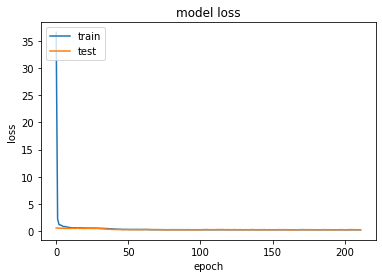

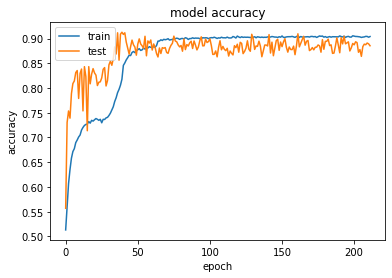

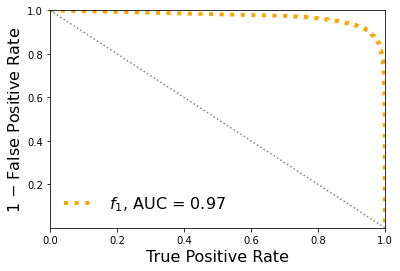

Classification score:


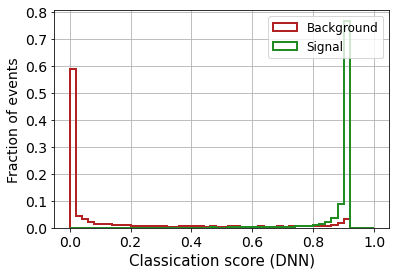


 ROC-AUC =  0.9717617365468981


In [50]:

# define the keras model
model = Sequential()
model.add(Dense(4, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

### CNN

In [45]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
40/40 [==============================] - 3s 29ms/step - loss: 0.5657 - accuracy: 0.7365 - val_loss: 0.3858 - val_accuracy: 0.8434
Epoch 2/500
40/40 [==============================] - 1s 25ms/step - loss: 0.3859 - accuracy: 0.8466 - val_loss: 0.3611 - val_accuracy: 0.8548
Epoch 3/500
40/40 [==============================] - 1s 25ms/step - loss: 0.3708 - accuracy: 0.8522 - val_loss: 0.3541 - val_accuracy: 0.8692
Epoch 4/500
40/40 [==============================] - 1s 25ms/step - loss: 0.3612 - accuracy: 0.8664 - val_loss: 0.3567 - val_accuracy: 0.8572
Epoch 5/500
40/40 [==============================] - 1s 25ms/step - loss: 0.3583 - accuracy: 0.8653 - val_loss: 0.3712 - val_accuracy: 0.8512
Epoch 6/500
40/40 [==============================] - 1s 25ms/step - loss: 0.3605 - accuracy: 0.8588 - val_loss: 0.3453 - val_accuracy: 0.8698
Epoch 7/500
40/40 [==============================] - 1s 25ms/step - loss: 0.3565 - accuracy: 0.8609 - val_loss: 0.3472 - val_accuracy: 0.8668
Epoch 

40/40 [==============================] - 1s 25ms/step - loss: 0.3201 - accuracy: 0.8859 - val_loss: 0.3519 - val_accuracy: 0.8722
Epoch 116/500
40/40 [==============================] - 1s 25ms/step - loss: 0.3341 - accuracy: 0.8773 - val_loss: 0.3518 - val_accuracy: 0.8692
Epoch 117/500
40/40 [==============================] - 1s 25ms/step - loss: 0.3151 - accuracy: 0.8871 - val_loss: 0.3403 - val_accuracy: 0.8740
Restoring model weights from the end of the best epoch.
Epoch 00117: early stopping


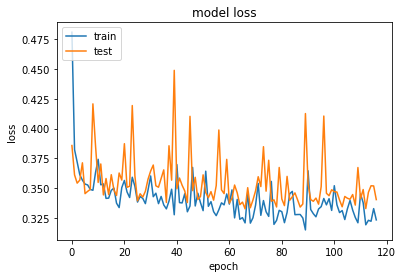

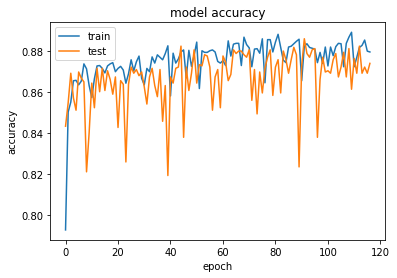

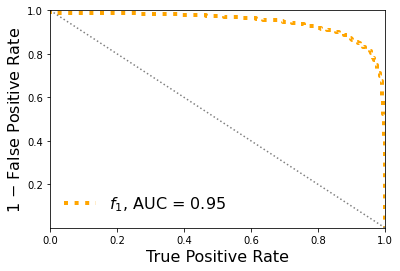

Classification score:


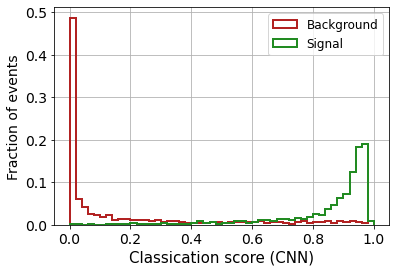


 ROC-AUC =  0.9469024541944178


In [37]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [38]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9469024541944178


Epoch 1/500
40/40 [==============================] - 3s 56ms/step - loss: 0.6219 - accuracy: 0.6965 - val_loss: 0.4309 - val_accuracy: 0.8254
Epoch 2/500
40/40 [==============================] - 2s 51ms/step - loss: 0.4061 - accuracy: 0.8500 - val_loss: 0.3820 - val_accuracy: 0.8548
Epoch 3/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3845 - accuracy: 0.8546 - val_loss: 0.3645 - val_accuracy: 0.8674
Epoch 4/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3799 - accuracy: 0.8644 - val_loss: 0.3855 - val_accuracy: 0.8506
Epoch 5/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3683 - accuracy: 0.8677 - val_loss: 0.3593 - val_accuracy: 0.8692
Epoch 6/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3598 - accuracy: 0.8731 - val_loss: 0.4195 - val_accuracy: 0.8284
Epoch 7/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3875 - accuracy: 0.8547 - val_loss: 0.3748 - val_accuracy: 0.8530
Epoch 

40/40 [==============================] - 2s 53ms/step - loss: 0.3300 - accuracy: 0.8767 - val_loss: 0.4603 - val_accuracy: 0.8188
Epoch 116/500
40/40 [==============================] - 2s 53ms/step - loss: 0.3596 - accuracy: 0.8670 - val_loss: 0.3674 - val_accuracy: 0.8644
Epoch 117/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3514 - accuracy: 0.8730 - val_loss: 0.3661 - val_accuracy: 0.8722
Epoch 118/500
40/40 [==============================] - 2s 53ms/step - loss: 0.3484 - accuracy: 0.8735 - val_loss: 0.3376 - val_accuracy: 0.8800
Epoch 119/500
40/40 [==============================] - 2s 53ms/step - loss: 0.3338 - accuracy: 0.8793 - val_loss: 0.3430 - val_accuracy: 0.8782
Epoch 120/500
40/40 [==============================] - 2s 53ms/step - loss: 0.3347 - accuracy: 0.8795 - val_loss: 0.3354 - val_accuracy: 0.8782
Epoch 121/500
40/40 [==============================] - 2s 56ms/step - loss: 0.3258 - accuracy: 0.8824 - val_loss: 0.3660 - val_accuracy: 0.8608
Epoch 

Epoch 172/500
40/40 [==============================] - 2s 53ms/step - loss: 0.3002 - accuracy: 0.8959 - val_loss: 0.3544 - val_accuracy: 0.8608
Epoch 173/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3389 - accuracy: 0.8750 - val_loss: 0.3393 - val_accuracy: 0.8800
Epoch 174/500
40/40 [==============================] - 2s 54ms/step - loss: 0.3406 - accuracy: 0.8737 - val_loss: 0.3307 - val_accuracy: 0.8848
Epoch 175/500
40/40 [==============================] - 2s 56ms/step - loss: 0.3172 - accuracy: 0.8868 - val_loss: 0.3378 - val_accuracy: 0.8788
Epoch 176/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3193 - accuracy: 0.8877 - val_loss: 0.3526 - val_accuracy: 0.8704
Epoch 177/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3166 - accuracy: 0.8930 - val_loss: 0.3526 - val_accuracy: 0.8782
Epoch 178/500
40/40 [==============================] - 2s 56ms/step - loss: 0.3267 - accuracy: 0.8835 - val_loss: 0.3754 - val_accuracy:

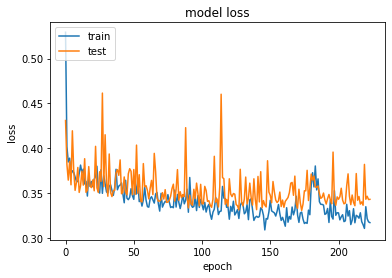

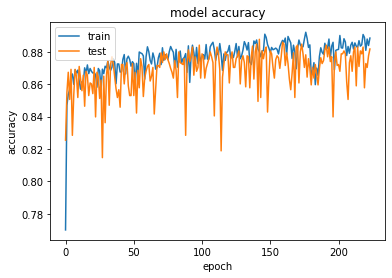

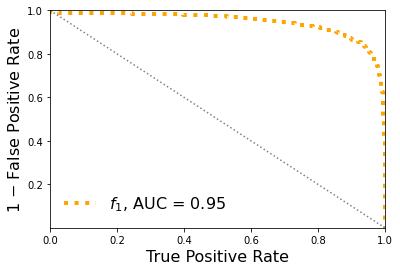

Classification score:


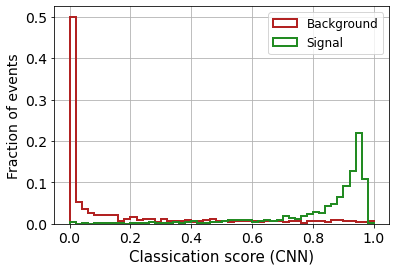


 ROC-AUC =  0.9464982449472042


In [39]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [40]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9464982449472042


Epoch 1/500
40/40 [==============================] - 5s 113ms/step - loss: 0.5984 - accuracy: 0.7107 - val_loss: 0.4012 - val_accuracy: 0.8344
Epoch 2/500
40/40 [==============================] - 4s 105ms/step - loss: 0.3972 - accuracy: 0.8403 - val_loss: 0.3993 - val_accuracy: 0.8332
Epoch 3/500
40/40 [==============================] - 4s 105ms/step - loss: 0.3972 - accuracy: 0.8440 - val_loss: 0.3845 - val_accuracy: 0.8488
Epoch 4/500
40/40 [==============================] - 4s 105ms/step - loss: 0.3856 - accuracy: 0.8485 - val_loss: 0.3657 - val_accuracy: 0.8518
Epoch 5/500
40/40 [==============================] - 4s 106ms/step - loss: 0.3621 - accuracy: 0.8597 - val_loss: 0.4325 - val_accuracy: 0.8188
Epoch 6/500
40/40 [==============================] - 4s 105ms/step - loss: 0.3992 - accuracy: 0.8447 - val_loss: 0.3574 - val_accuracy: 0.8638
Epoch 7/500
40/40 [==============================] - 4s 105ms/step - loss: 0.3661 - accuracy: 0.8595 - val_loss: 0.3688 - val_accuracy: 0.8518

Epoch 58/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3642 - accuracy: 0.8647 - val_loss: 0.3487 - val_accuracy: 0.8728
Epoch 59/500
40/40 [==============================] - 4s 106ms/step - loss: 0.3473 - accuracy: 0.8791 - val_loss: 0.3495 - val_accuracy: 0.8692
Epoch 60/500
40/40 [==============================] - 4s 106ms/step - loss: 0.3421 - accuracy: 0.8744 - val_loss: 0.3474 - val_accuracy: 0.8692
Epoch 61/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3299 - accuracy: 0.8776 - val_loss: 0.3469 - val_accuracy: 0.8734
Epoch 62/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3379 - accuracy: 0.8820 - val_loss: 0.3423 - val_accuracy: 0.8764
Epoch 63/500
40/40 [==============================] - 4s 106ms/step - loss: 0.3271 - accuracy: 0.8784 - val_loss: 0.3423 - val_accuracy: 0.8824
Epoch 64/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3526 - accuracy: 0.8661 - val_loss: 0.3467 - val_accuracy:

Epoch 115/500
40/40 [==============================] - 4s 106ms/step - loss: 0.3640 - accuracy: 0.8687 - val_loss: 0.3447 - val_accuracy: 0.8734
Epoch 116/500
40/40 [==============================] - 4s 106ms/step - loss: 0.3395 - accuracy: 0.8771 - val_loss: 0.3360 - val_accuracy: 0.8770
Epoch 117/500
40/40 [==============================] - 4s 106ms/step - loss: 0.3461 - accuracy: 0.8677 - val_loss: 0.3505 - val_accuracy: 0.8770
Epoch 118/500
40/40 [==============================] - 4s 106ms/step - loss: 0.3590 - accuracy: 0.8695 - val_loss: 0.3476 - val_accuracy: 0.8674
Epoch 119/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3414 - accuracy: 0.8776 - val_loss: 0.3447 - val_accuracy: 0.8824
Epoch 120/500
40/40 [==============================] - 4s 106ms/step - loss: 0.3365 - accuracy: 0.8771 - val_loss: 0.3424 - val_accuracy: 0.8692
Epoch 121/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3262 - accuracy: 0.8899 - val_loss: 0.3393 - val_ac

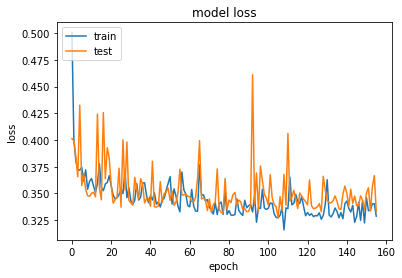

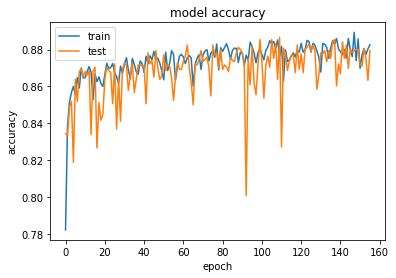

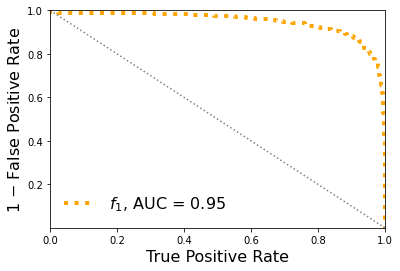

Classification score:


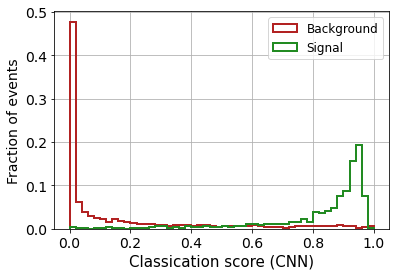


 ROC-AUC =  0.9488155193314962


In [41]:

# define the keras model
model = Sequential()
model.add(Conv1D(32, 2, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [42]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9488155193314962


Epoch 1/500
40/40 [==============================] - 2s 33ms/step - loss: 0.5710 - accuracy: 0.7398 - val_loss: 0.4656 - val_accuracy: 0.7990
Epoch 2/500
40/40 [==============================] - 1s 28ms/step - loss: 0.4095 - accuracy: 0.8395 - val_loss: 0.3715 - val_accuracy: 0.8482
Epoch 3/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3758 - accuracy: 0.8520 - val_loss: 0.3796 - val_accuracy: 0.8440
Epoch 4/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3739 - accuracy: 0.8569 - val_loss: 0.3572 - val_accuracy: 0.8584
Epoch 5/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3675 - accuracy: 0.8605 - val_loss: 0.3803 - val_accuracy: 0.8452
Epoch 6/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3889 - accuracy: 0.8519 - val_loss: 0.3727 - val_accuracy: 0.8488
Epoch 7/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3608 - accuracy: 0.8617 - val_loss: 0.3611 - val_accuracy: 0.8572
Epoch 

40/40 [==============================] - 1s 27ms/step - loss: 0.3157 - accuracy: 0.8833 - val_loss: 0.3853 - val_accuracy: 0.8620
Epoch 116/500
40/40 [==============================] - 1s 27ms/step - loss: 0.3448 - accuracy: 0.8754 - val_loss: 0.3270 - val_accuracy: 0.8824
Epoch 117/500
40/40 [==============================] - 1s 27ms/step - loss: 0.3233 - accuracy: 0.8847 - val_loss: 0.3305 - val_accuracy: 0.8794
Epoch 118/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3146 - accuracy: 0.8917 - val_loss: 0.3313 - val_accuracy: 0.8836
Epoch 119/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3305 - accuracy: 0.8800 - val_loss: 0.3312 - val_accuracy: 0.8776
Epoch 120/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3314 - accuracy: 0.8786 - val_loss: 0.3273 - val_accuracy: 0.8818
Epoch 121/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3152 - accuracy: 0.8868 - val_loss: 0.3424 - val_accuracy: 0.8812
Epoch 

Epoch 172/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3144 - accuracy: 0.8917 - val_loss: 0.3576 - val_accuracy: 0.8638
Epoch 173/500
40/40 [==============================] - 1s 27ms/step - loss: 0.3145 - accuracy: 0.8882 - val_loss: 0.3491 - val_accuracy: 0.8662
Epoch 174/500
40/40 [==============================] - 1s 27ms/step - loss: 0.3128 - accuracy: 0.8867 - val_loss: 0.3387 - val_accuracy: 0.8818
Epoch 175/500
40/40 [==============================] - 1s 27ms/step - loss: 0.3027 - accuracy: 0.8986 - val_loss: 0.3234 - val_accuracy: 0.8848
Epoch 176/500
40/40 [==============================] - 1s 27ms/step - loss: 0.3040 - accuracy: 0.8942 - val_loss: 0.3319 - val_accuracy: 0.8764
Epoch 177/500
40/40 [==============================] - 1s 27ms/step - loss: 0.2954 - accuracy: 0.8939 - val_loss: 0.3241 - val_accuracy: 0.8908
Epoch 178/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3257 - accuracy: 0.8826 - val_loss: 0.3422 - val_accuracy:

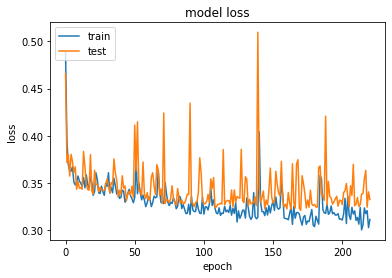

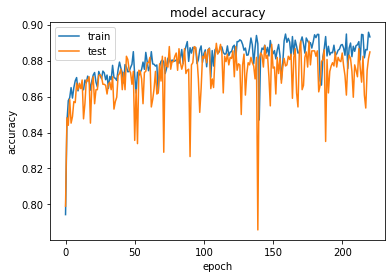

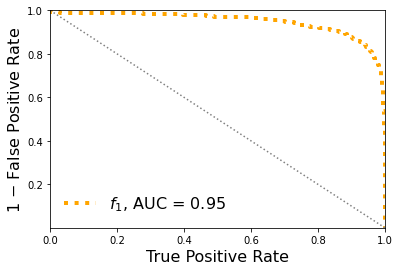

Classification score:


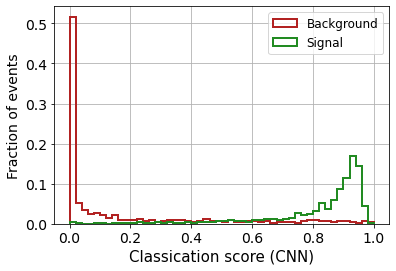


 ROC-AUC =  0.9484505432169152


In [43]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [44]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9484505432169152


Epoch 1/500
40/40 [==============================] - 3s 60ms/step - loss: 0.5397 - accuracy: 0.7617 - val_loss: 0.3952 - val_accuracy: 0.8440
Epoch 2/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3851 - accuracy: 0.8505 - val_loss: 0.3734 - val_accuracy: 0.8542
Epoch 3/500
40/40 [==============================] - 2s 55ms/step - loss: 0.4031 - accuracy: 0.8531 - val_loss: 0.3695 - val_accuracy: 0.8560
Epoch 4/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3785 - accuracy: 0.8592 - val_loss: 0.3590 - val_accuracy: 0.8620
Epoch 5/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3613 - accuracy: 0.8674 - val_loss: 0.4648 - val_accuracy: 0.8116
Epoch 6/500
40/40 [==============================] - 2s 55ms/step - loss: 0.4008 - accuracy: 0.8423 - val_loss: 0.3555 - val_accuracy: 0.8662
Epoch 7/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3649 - accuracy: 0.8622 - val_loss: 0.3511 - val_accuracy: 0.8686
Epoch 

40/40 [==============================] - 2s 53ms/step - loss: 0.3260 - accuracy: 0.8792 - val_loss: 0.3420 - val_accuracy: 0.8686
Epoch 116/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3290 - accuracy: 0.8852 - val_loss: 0.3232 - val_accuracy: 0.8878
Epoch 117/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3160 - accuracy: 0.8806 - val_loss: 0.3312 - val_accuracy: 0.8788
Epoch 118/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3263 - accuracy: 0.8836 - val_loss: 0.3549 - val_accuracy: 0.8614
Epoch 119/500
40/40 [==============================] - 2s 53ms/step - loss: 0.3676 - accuracy: 0.8639 - val_loss: 0.3717 - val_accuracy: 0.8590
Epoch 120/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3545 - accuracy: 0.8747 - val_loss: 0.3317 - val_accuracy: 0.8794
Epoch 121/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3310 - accuracy: 0.8771 - val_loss: 0.3286 - val_accuracy: 0.8812
Epoch 

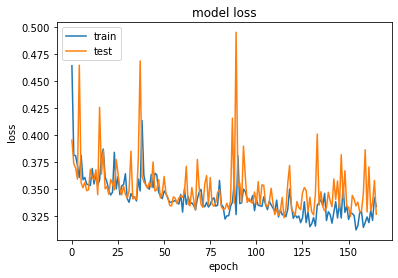

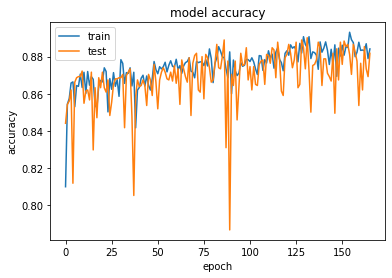

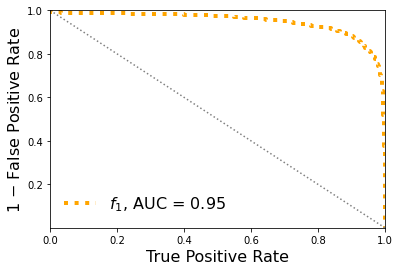

Classification score:


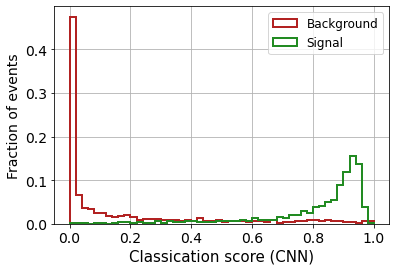


 ROC-AUC =  0.9492506831604197


In [45]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [46]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9492506831604197


Epoch 1/500
40/40 [==============================] - 5s 116ms/step - loss: 0.5707 - accuracy: 0.7093 - val_loss: 0.3892 - val_accuracy: 0.8416
Epoch 2/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3902 - accuracy: 0.8498 - val_loss: 0.3660 - val_accuracy: 0.8548
Epoch 3/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3722 - accuracy: 0.8550 - val_loss: 0.4043 - val_accuracy: 0.8338
Epoch 4/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3867 - accuracy: 0.8508 - val_loss: 0.3770 - val_accuracy: 0.8536
Epoch 5/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3845 - accuracy: 0.8507 - val_loss: 0.3817 - val_accuracy: 0.8482
Epoch 6/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3846 - accuracy: 0.8534 - val_loss: 0.3897 - val_accuracy: 0.8410
Epoch 7/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3551 - accuracy: 0.8607 - val_loss: 0.3508 - val_accuracy: 0.8650

Epoch 58/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3534 - accuracy: 0.8766 - val_loss: 0.3558 - val_accuracy: 0.8680
Epoch 59/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3716 - accuracy: 0.8613 - val_loss: 0.3613 - val_accuracy: 0.8596
Epoch 60/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3510 - accuracy: 0.8732 - val_loss: 0.3497 - val_accuracy: 0.8698
Epoch 61/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3452 - accuracy: 0.8716 - val_loss: 0.3405 - val_accuracy: 0.8752
Epoch 62/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3442 - accuracy: 0.8736 - val_loss: 0.3931 - val_accuracy: 0.8428
Epoch 63/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3672 - accuracy: 0.8643 - val_loss: 0.3481 - val_accuracy: 0.8710
Epoch 64/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3486 - accuracy: 0.8644 - val_loss: 0.3405 - val_accuracy:

Epoch 115/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3153 - accuracy: 0.8851 - val_loss: 0.3446 - val_accuracy: 0.8638
Epoch 116/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3587 - accuracy: 0.8635 - val_loss: 0.3331 - val_accuracy: 0.8788
Epoch 117/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3478 - accuracy: 0.8756 - val_loss: 0.3420 - val_accuracy: 0.8680
Epoch 118/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3556 - accuracy: 0.8734 - val_loss: 0.3297 - val_accuracy: 0.8776
Epoch 119/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3443 - accuracy: 0.8703 - val_loss: 0.3293 - val_accuracy: 0.8746
Epoch 120/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3335 - accuracy: 0.8839 - val_loss: 0.3634 - val_accuracy: 0.8518
Epoch 121/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3435 - accuracy: 0.8693 - val_loss: 0.3285 - val_ac

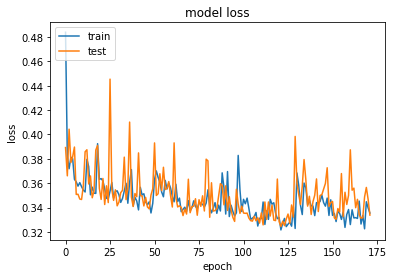

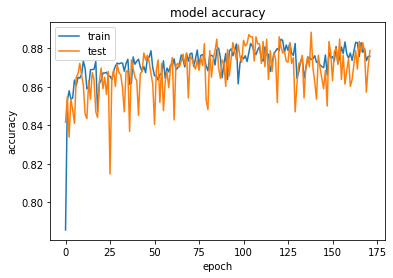

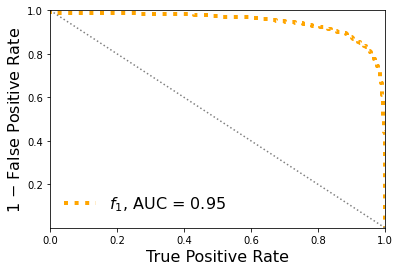

Classification score:


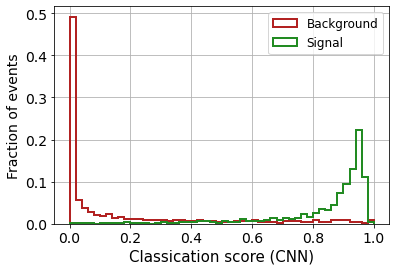


 ROC-AUC =  0.948951215579225


In [47]:

# define the keras model
model = Sequential()
model.add(Conv1D(32, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [48]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.948951215579225


##### 2 conv layers

Epoch 1/500
40/40 [==============================] - 2s 44ms/step - loss: 0.6019 - accuracy: 0.7286 - val_loss: 0.4274 - val_accuracy: 0.8392
Epoch 2/500
40/40 [==============================] - 2s 39ms/step - loss: 0.4320 - accuracy: 0.8403 - val_loss: 0.3856 - val_accuracy: 0.8632
Epoch 3/500
40/40 [==============================] - 2s 39ms/step - loss: 0.4063 - accuracy: 0.8529 - val_loss: 0.3794 - val_accuracy: 0.8650
Epoch 4/500
40/40 [==============================] - 2s 39ms/step - loss: 0.3833 - accuracy: 0.8669 - val_loss: 0.4437 - val_accuracy: 0.8308
Epoch 5/500
40/40 [==============================] - 2s 39ms/step - loss: 0.4150 - accuracy: 0.8477 - val_loss: 0.3756 - val_accuracy: 0.8626
Epoch 6/500
40/40 [==============================] - 2s 39ms/step - loss: 0.3819 - accuracy: 0.8641 - val_loss: 0.3633 - val_accuracy: 0.8698
Epoch 7/500
40/40 [==============================] - 2s 39ms/step - loss: 0.3691 - accuracy: 0.8630 - val_loss: 0.3597 - val_accuracy: 0.8656
Epoch 

40/40 [==============================] - 2s 38ms/step - loss: 0.3641 - accuracy: 0.8742 - val_loss: 0.3385 - val_accuracy: 0.8854
Epoch 116/500
40/40 [==============================] - 2s 38ms/step - loss: 0.3135 - accuracy: 0.8901 - val_loss: 0.3364 - val_accuracy: 0.8794
Epoch 117/500
40/40 [==============================] - 2s 38ms/step - loss: 0.3222 - accuracy: 0.8856 - val_loss: 0.3442 - val_accuracy: 0.8830
Epoch 118/500
40/40 [==============================] - 2s 38ms/step - loss: 0.3377 - accuracy: 0.8767 - val_loss: 0.3424 - val_accuracy: 0.8764
Epoch 119/500
40/40 [==============================] - 2s 38ms/step - loss: 0.3291 - accuracy: 0.8855 - val_loss: 0.3367 - val_accuracy: 0.8812
Epoch 120/500
40/40 [==============================] - 2s 38ms/step - loss: 0.3268 - accuracy: 0.8843 - val_loss: 0.3620 - val_accuracy: 0.8662
Epoch 121/500
40/40 [==============================] - 2s 38ms/step - loss: 0.3829 - accuracy: 0.8535 - val_loss: 0.3508 - val_accuracy: 0.8674
Epoch 

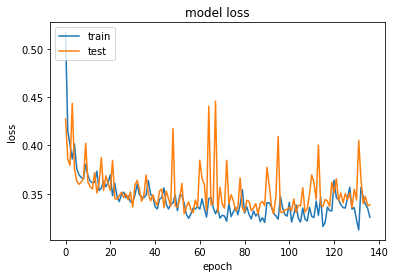

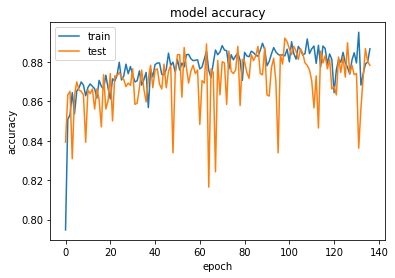

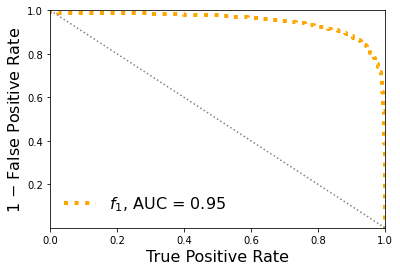

Classification score:


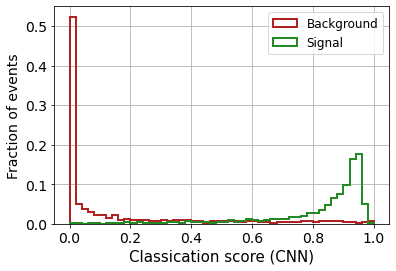


 ROC-AUC =  0.9499183662891648


In [49]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(8, 2, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [50]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9499183662891648


Epoch 1/500
40/40 [==============================] - 4s 82ms/step - loss: 0.6604 - accuracy: 0.7109 - val_loss: 0.4639 - val_accuracy: 0.8302
Epoch 2/500
40/40 [==============================] - 3s 77ms/step - loss: 0.4559 - accuracy: 0.8455 - val_loss: 0.4120 - val_accuracy: 0.8608
Epoch 3/500
40/40 [==============================] - 3s 76ms/step - loss: 0.4243 - accuracy: 0.8509 - val_loss: 0.3991 - val_accuracy: 0.8572
Epoch 4/500
40/40 [==============================] - 3s 77ms/step - loss: 0.3933 - accuracy: 0.8650 - val_loss: 0.3848 - val_accuracy: 0.8710
Epoch 5/500
40/40 [==============================] - 3s 76ms/step - loss: 0.3890 - accuracy: 0.8627 - val_loss: 0.3898 - val_accuracy: 0.8704
Epoch 6/500
40/40 [==============================] - 3s 77ms/step - loss: 0.3962 - accuracy: 0.8657 - val_loss: 0.3729 - val_accuracy: 0.8668
Epoch 7/500
40/40 [==============================] - 3s 77ms/step - loss: 0.3732 - accuracy: 0.8714 - val_loss: 0.3953 - val_accuracy: 0.8464
Epoch 

40/40 [==============================] - 3s 76ms/step - loss: 0.3310 - accuracy: 0.8789 - val_loss: 0.3302 - val_accuracy: 0.8782
Epoch 116/500
40/40 [==============================] - 3s 76ms/step - loss: 0.3345 - accuracy: 0.8792 - val_loss: 0.3256 - val_accuracy: 0.8848
Epoch 117/500
40/40 [==============================] - 3s 76ms/step - loss: 0.3178 - accuracy: 0.8902 - val_loss: 0.3300 - val_accuracy: 0.8860
Epoch 118/500
40/40 [==============================] - 3s 76ms/step - loss: 0.3180 - accuracy: 0.8923 - val_loss: 0.3301 - val_accuracy: 0.8794
Epoch 119/500
40/40 [==============================] - 3s 76ms/step - loss: 0.3240 - accuracy: 0.8855 - val_loss: 0.3320 - val_accuracy: 0.8878
Epoch 120/500
40/40 [==============================] - 3s 76ms/step - loss: 0.3307 - accuracy: 0.8863 - val_loss: 0.3713 - val_accuracy: 0.8650
Epoch 121/500
40/40 [==============================] - 3s 76ms/step - loss: 0.3465 - accuracy: 0.8757 - val_loss: 0.3455 - val_accuracy: 0.8698
Epoch 

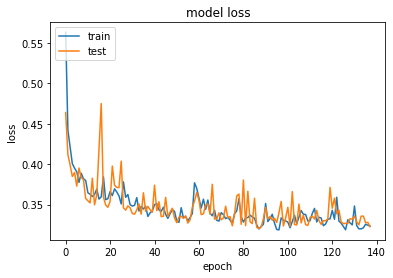

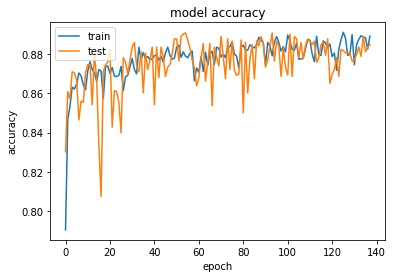

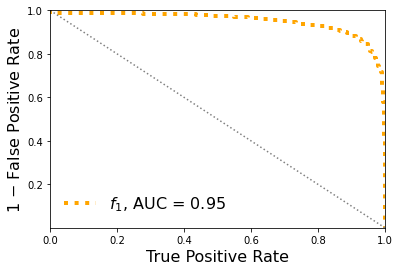

Classification score:


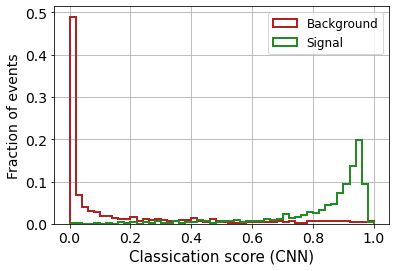


 ROC-AUC =  0.951465735437669


In [51]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(16, 2, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [52]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.951465735437669


Epoch 1/500
40/40 [==============================] - 7s 164ms/step - loss: 0.7426 - accuracy: 0.7258 - val_loss: 0.5123 - val_accuracy: 0.8386
Epoch 2/500
40/40 [==============================] - 6s 159ms/step - loss: 0.4904 - accuracy: 0.8526 - val_loss: 0.4732 - val_accuracy: 0.8434
Epoch 3/500
40/40 [==============================] - 6s 158ms/step - loss: 0.4811 - accuracy: 0.8501 - val_loss: 0.4256 - val_accuracy: 0.8590
Epoch 4/500
40/40 [==============================] - 6s 158ms/step - loss: 0.4300 - accuracy: 0.8594 - val_loss: 0.3956 - val_accuracy: 0.8680
Epoch 5/500
40/40 [==============================] - 6s 158ms/step - loss: 0.4075 - accuracy: 0.8660 - val_loss: 0.4203 - val_accuracy: 0.8494
Epoch 6/500
40/40 [==============================] - 6s 158ms/step - loss: 0.3966 - accuracy: 0.8634 - val_loss: 0.3766 - val_accuracy: 0.8692
Epoch 7/500
40/40 [==============================] - 6s 158ms/step - loss: 0.3940 - accuracy: 0.8610 - val_loss: 0.3808 - val_accuracy: 0.8662

Epoch 58/500
40/40 [==============================] - 6s 161ms/step - loss: 0.3488 - accuracy: 0.8795 - val_loss: 0.3275 - val_accuracy: 0.8908
Epoch 59/500
40/40 [==============================] - 6s 160ms/step - loss: 0.3300 - accuracy: 0.8829 - val_loss: 0.3381 - val_accuracy: 0.8758
Epoch 60/500
40/40 [==============================] - 6s 160ms/step - loss: 0.3325 - accuracy: 0.8815 - val_loss: 0.3328 - val_accuracy: 0.8842
Epoch 61/500
40/40 [==============================] - 6s 160ms/step - loss: 0.3359 - accuracy: 0.8865 - val_loss: 0.3246 - val_accuracy: 0.8836
Epoch 62/500
40/40 [==============================] - 6s 161ms/step - loss: 0.3338 - accuracy: 0.8845 - val_loss: 0.3253 - val_accuracy: 0.8848
Epoch 63/500
40/40 [==============================] - 6s 161ms/step - loss: 0.3328 - accuracy: 0.8792 - val_loss: 0.3257 - val_accuracy: 0.8842
Epoch 64/500
40/40 [==============================] - 6s 160ms/step - loss: 0.3395 - accuracy: 0.8840 - val_loss: 0.3605 - val_accuracy:

Epoch 115/500
40/40 [==============================] - 6s 159ms/step - loss: 0.3237 - accuracy: 0.8842 - val_loss: 0.3315 - val_accuracy: 0.8914
Epoch 116/500
40/40 [==============================] - 6s 158ms/step - loss: 0.3157 - accuracy: 0.8883 - val_loss: 0.3231 - val_accuracy: 0.8866
Epoch 117/500
40/40 [==============================] - 6s 158ms/step - loss: 0.3192 - accuracy: 0.8948 - val_loss: 0.3202 - val_accuracy: 0.8914
Epoch 118/500
40/40 [==============================] - 6s 159ms/step - loss: 0.3250 - accuracy: 0.8890 - val_loss: 0.3222 - val_accuracy: 0.8914
Epoch 119/500
40/40 [==============================] - 6s 158ms/step - loss: 0.3184 - accuracy: 0.8891 - val_loss: 0.3298 - val_accuracy: 0.8806
Epoch 120/500
40/40 [==============================] - 6s 158ms/step - loss: 0.3247 - accuracy: 0.8900 - val_loss: 0.3387 - val_accuracy: 0.8848
Epoch 121/500
40/40 [==============================] - 6s 158ms/step - loss: 0.3203 - accuracy: 0.8816 - val_loss: 0.3213 - val_ac

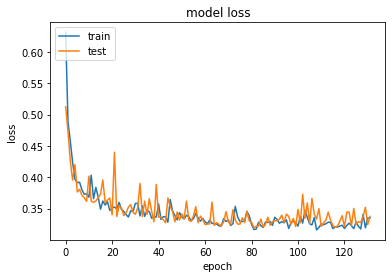

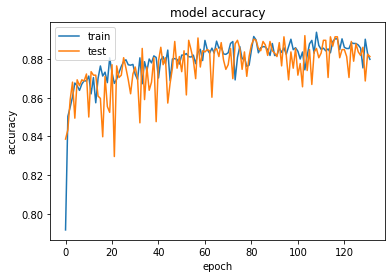

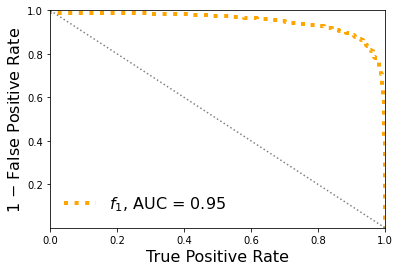

Classification score:


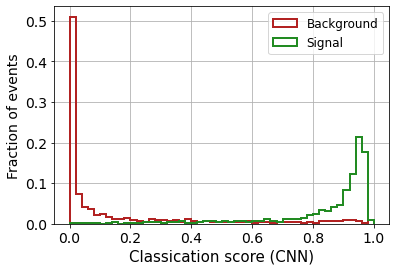


 ROC-AUC =  0.9510446091516142


In [53]:

# define the keras model
model = Sequential()
model.add(Conv1D(32, 2, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 2, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [54]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9510446091516142


Epoch 1/500
40/40 [==============================] - 3s 46ms/step - loss: 0.6258 - accuracy: 0.6924 - val_loss: 0.4202 - val_accuracy: 0.8416
Epoch 2/500
40/40 [==============================] - 2s 41ms/step - loss: 0.4230 - accuracy: 0.8481 - val_loss: 0.3836 - val_accuracy: 0.8608
Epoch 3/500
40/40 [==============================] - 2s 41ms/step - loss: 0.3924 - accuracy: 0.8572 - val_loss: 0.4529 - val_accuracy: 0.8182
Epoch 4/500
40/40 [==============================] - 2s 41ms/step - loss: 0.4184 - accuracy: 0.8444 - val_loss: 0.3730 - val_accuracy: 0.8590
Epoch 5/500
40/40 [==============================] - 2s 41ms/step - loss: 0.3848 - accuracy: 0.8586 - val_loss: 0.3683 - val_accuracy: 0.8656
Epoch 6/500
40/40 [==============================] - 2s 41ms/step - loss: 0.3811 - accuracy: 0.8583 - val_loss: 0.3910 - val_accuracy: 0.8470
Epoch 7/500
40/40 [==============================] - 2s 41ms/step - loss: 0.3872 - accuracy: 0.8604 - val_loss: 0.3623 - val_accuracy: 0.8626
Epoch 

40/40 [==============================] - 2s 40ms/step - loss: 0.3268 - accuracy: 0.8843 - val_loss: 0.3301 - val_accuracy: 0.8878
Epoch 116/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3269 - accuracy: 0.8808 - val_loss: 0.3300 - val_accuracy: 0.8884
Epoch 117/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3440 - accuracy: 0.8739 - val_loss: 0.3297 - val_accuracy: 0.8758
Epoch 118/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3307 - accuracy: 0.8819 - val_loss: 0.3254 - val_accuracy: 0.8908
Epoch 119/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3286 - accuracy: 0.8866 - val_loss: 0.3419 - val_accuracy: 0.8704
Epoch 120/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3166 - accuracy: 0.8824 - val_loss: 0.3145 - val_accuracy: 0.8902
Epoch 121/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3166 - accuracy: 0.8846 - val_loss: 0.3393 - val_accuracy: 0.8848
Epoch 

Epoch 172/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3173 - accuracy: 0.8894 - val_loss: 0.3186 - val_accuracy: 0.8914
Epoch 173/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3143 - accuracy: 0.8894 - val_loss: 0.3228 - val_accuracy: 0.8842
Epoch 174/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3121 - accuracy: 0.8883 - val_loss: 0.3318 - val_accuracy: 0.8800
Epoch 175/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3253 - accuracy: 0.8834 - val_loss: 0.3124 - val_accuracy: 0.8926
Epoch 176/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3082 - accuracy: 0.8879 - val_loss: 0.3154 - val_accuracy: 0.8860
Epoch 177/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3208 - accuracy: 0.8829 - val_loss: 0.3108 - val_accuracy: 0.8908
Epoch 178/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3021 - accuracy: 0.8982 - val_loss: 0.3152 - val_accuracy:

Epoch 229/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3140 - accuracy: 0.8870 - val_loss: 0.3168 - val_accuracy: 0.8878
Epoch 230/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3077 - accuracy: 0.8885 - val_loss: 0.3390 - val_accuracy: 0.8710
Epoch 231/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3415 - accuracy: 0.8730 - val_loss: 0.3210 - val_accuracy: 0.8788
Epoch 232/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3062 - accuracy: 0.8996 - val_loss: 0.3197 - val_accuracy: 0.8848
Epoch 233/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3134 - accuracy: 0.8887 - val_loss: 0.3211 - val_accuracy: 0.8866
Epoch 234/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3134 - accuracy: 0.8890 - val_loss: 0.3243 - val_accuracy: 0.8956
Epoch 235/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3225 - accuracy: 0.8826 - val_loss: 0.3143 - val_accuracy:

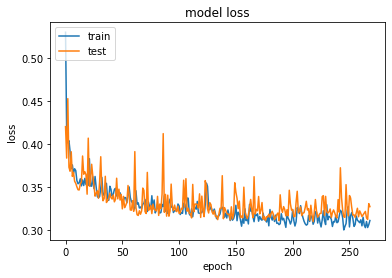

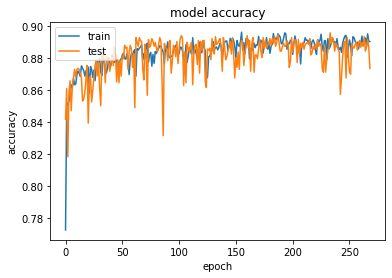

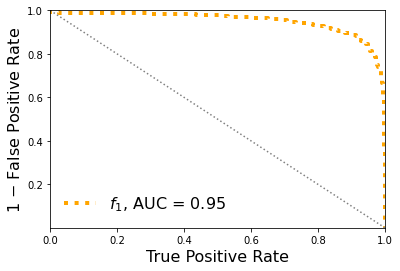

Classification score:


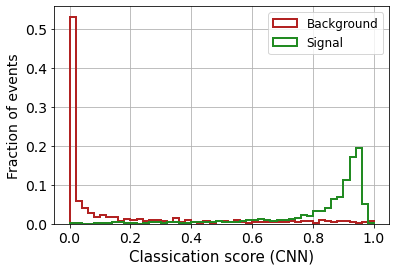


 ROC-AUC =  0.9520823075128929


In [55]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(8, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [56]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9520823075128929


Epoch 1/500
40/40 [==============================] - 4s 87ms/step - loss: 0.6438 - accuracy: 0.7391 - val_loss: 0.4931 - val_accuracy: 0.8230
Epoch 2/500
40/40 [==============================] - 3s 81ms/step - loss: 0.4618 - accuracy: 0.8370 - val_loss: 0.4115 - val_accuracy: 0.8542
Epoch 3/500
40/40 [==============================] - 3s 81ms/step - loss: 0.4126 - accuracy: 0.8660 - val_loss: 0.3936 - val_accuracy: 0.8614
Epoch 4/500
40/40 [==============================] - 3s 81ms/step - loss: 0.3981 - accuracy: 0.8649 - val_loss: 0.3850 - val_accuracy: 0.8686
Epoch 5/500
40/40 [==============================] - 3s 81ms/step - loss: 0.4414 - accuracy: 0.8389 - val_loss: 0.3844 - val_accuracy: 0.8602
Epoch 6/500
40/40 [==============================] - 3s 81ms/step - loss: 0.3799 - accuracy: 0.8705 - val_loss: 0.3645 - val_accuracy: 0.8716
Epoch 7/500
40/40 [==============================] - 3s 81ms/step - loss: 0.3513 - accuracy: 0.8836 - val_loss: 0.3662 - val_accuracy: 0.8734
Epoch 

40/40 [==============================] - 3s 81ms/step - loss: 0.3147 - accuracy: 0.8873 - val_loss: 0.3118 - val_accuracy: 0.8872
Epoch 116/500
40/40 [==============================] - 3s 81ms/step - loss: 0.3315 - accuracy: 0.8769 - val_loss: 0.3331 - val_accuracy: 0.8818
Epoch 117/500
40/40 [==============================] - 3s 81ms/step - loss: 0.3299 - accuracy: 0.8804 - val_loss: 0.3391 - val_accuracy: 0.8698
Epoch 118/500
40/40 [==============================] - 3s 81ms/step - loss: 0.3588 - accuracy: 0.8703 - val_loss: 0.3265 - val_accuracy: 0.8806
Epoch 119/500
40/40 [==============================] - 3s 81ms/step - loss: 0.3230 - accuracy: 0.8907 - val_loss: 0.3168 - val_accuracy: 0.8860
Epoch 120/500
40/40 [==============================] - 3s 81ms/step - loss: 0.3152 - accuracy: 0.8879 - val_loss: 0.3385 - val_accuracy: 0.8770
Epoch 121/500
40/40 [==============================] - 3s 81ms/step - loss: 0.3244 - accuracy: 0.8774 - val_loss: 0.3194 - val_accuracy: 0.8920
Epoch 

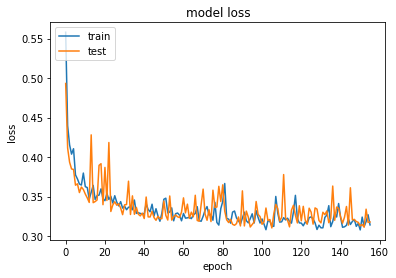

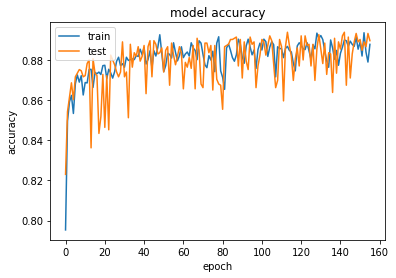

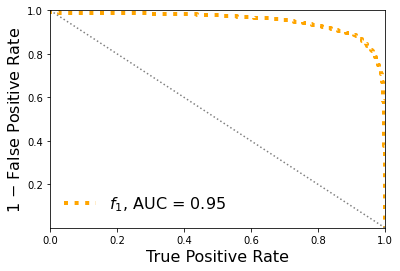

Classification score:


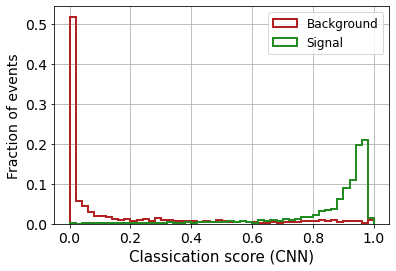


 ROC-AUC =  0.9527525102006145


In [57]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(16, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [58]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9527525102006145


Epoch 1/500
40/40 [==============================] - 8s 174ms/step - loss: 0.7083 - accuracy: 0.7451 - val_loss: 0.5178 - val_accuracy: 0.8308
Epoch 2/500
40/40 [==============================] - 7s 168ms/step - loss: 0.5119 - accuracy: 0.8403 - val_loss: 0.4319 - val_accuracy: 0.8602
Epoch 3/500
40/40 [==============================] - 7s 169ms/step - loss: 0.4299 - accuracy: 0.8672 - val_loss: 0.4150 - val_accuracy: 0.8560
Epoch 4/500
40/40 [==============================] - 7s 170ms/step - loss: 0.4088 - accuracy: 0.8664 - val_loss: 0.4357 - val_accuracy: 0.8428
Epoch 5/500
40/40 [==============================] - 7s 170ms/step - loss: 0.4114 - accuracy: 0.8528 - val_loss: 0.3777 - val_accuracy: 0.8734
Epoch 6/500
40/40 [==============================] - 7s 168ms/step - loss: 0.4065 - accuracy: 0.8606 - val_loss: 0.3796 - val_accuracy: 0.8590
Epoch 7/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3875 - accuracy: 0.8619 - val_loss: 0.5336 - val_accuracy: 0.7858

Epoch 58/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3139 - accuracy: 0.8848 - val_loss: 0.3375 - val_accuracy: 0.8716
Epoch 59/500
40/40 [==============================] - 7s 169ms/step - loss: 0.3357 - accuracy: 0.8765 - val_loss: 0.3235 - val_accuracy: 0.8860
Epoch 60/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3210 - accuracy: 0.8815 - val_loss: 0.3229 - val_accuracy: 0.8842
Epoch 61/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3243 - accuracy: 0.8865 - val_loss: 0.3179 - val_accuracy: 0.8908
Epoch 62/500
40/40 [==============================] - 7s 169ms/step - loss: 0.3127 - accuracy: 0.8938 - val_loss: 0.3229 - val_accuracy: 0.8788
Epoch 63/500
40/40 [==============================] - 7s 169ms/step - loss: 0.3205 - accuracy: 0.8868 - val_loss: 0.3268 - val_accuracy: 0.8920
Epoch 64/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3169 - accuracy: 0.8904 - val_loss: 0.3239 - val_accuracy:

Epoch 115/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3225 - accuracy: 0.8844 - val_loss: 0.3256 - val_accuracy: 0.8752
Epoch 116/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3367 - accuracy: 0.8786 - val_loss: 0.3200 - val_accuracy: 0.8848
Epoch 117/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3218 - accuracy: 0.8864 - val_loss: 0.3674 - val_accuracy: 0.8626
Epoch 118/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3585 - accuracy: 0.8658 - val_loss: 0.3384 - val_accuracy: 0.8878
Epoch 119/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3154 - accuracy: 0.8852 - val_loss: 0.3165 - val_accuracy: 0.8884
Epoch 120/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3117 - accuracy: 0.8866 - val_loss: 0.3175 - val_accuracy: 0.8878
Epoch 121/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3113 - accuracy: 0.8910 - val_loss: 0.3129 - val_ac

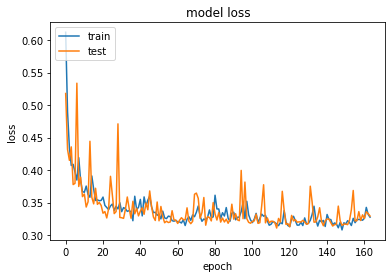

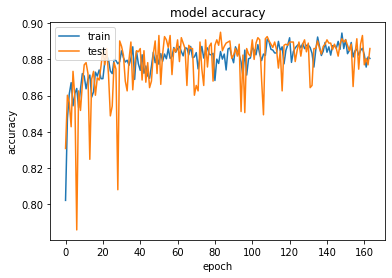

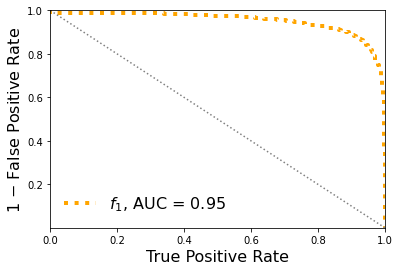

Classification score:


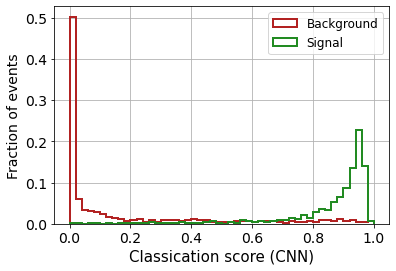


 ROC-AUC =  0.952405530935865


In [59]:

# define the keras model
model = Sequential()
model.add(Conv1D(32, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [60]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.952405530935865


##### 3 conv layers

Epoch 1/500
40/40 [==============================] - 3s 62ms/step - loss: 0.6700 - accuracy: 0.7190 - val_loss: 0.4715 - val_accuracy: 0.8422
Epoch 2/500
40/40 [==============================] - 2s 56ms/step - loss: 0.4493 - accuracy: 0.8523 - val_loss: 0.4436 - val_accuracy: 0.8452
Epoch 3/500
40/40 [==============================] - 2s 56ms/step - loss: 0.4209 - accuracy: 0.8641 - val_loss: 0.4161 - val_accuracy: 0.8548
Epoch 4/500
40/40 [==============================] - 2s 56ms/step - loss: 0.4155 - accuracy: 0.8545 - val_loss: 0.4007 - val_accuracy: 0.8650
Epoch 5/500
40/40 [==============================] - 2s 56ms/step - loss: 0.4143 - accuracy: 0.8608 - val_loss: 0.4163 - val_accuracy: 0.8494
Epoch 6/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3891 - accuracy: 0.8702 - val_loss: 0.3734 - val_accuracy: 0.8722
Epoch 7/500
40/40 [==============================] - 2s 56ms/step - loss: 0.3935 - accuracy: 0.8652 - val_loss: 0.3723 - val_accuracy: 0.8746
Epoch 

40/40 [==============================] - 2s 55ms/step - loss: 0.3363 - accuracy: 0.8811 - val_loss: 0.3149 - val_accuracy: 0.8860
Epoch 116/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3227 - accuracy: 0.8884 - val_loss: 0.3347 - val_accuracy: 0.8848
Epoch 117/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3392 - accuracy: 0.8762 - val_loss: 0.3346 - val_accuracy: 0.8818
Epoch 118/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3387 - accuracy: 0.8755 - val_loss: 0.3332 - val_accuracy: 0.8746
Epoch 119/500
40/40 [==============================] - 2s 54ms/step - loss: 0.3253 - accuracy: 0.8814 - val_loss: 0.3198 - val_accuracy: 0.8878
Epoch 120/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3259 - accuracy: 0.8831 - val_loss: 0.3259 - val_accuracy: 0.8758
Epoch 121/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3183 - accuracy: 0.8895 - val_loss: 0.3572 - val_accuracy: 0.8686
Epoch 

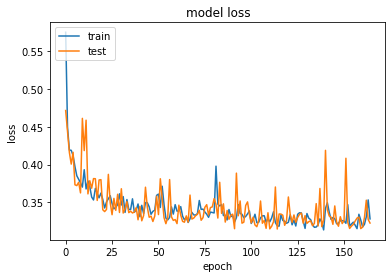

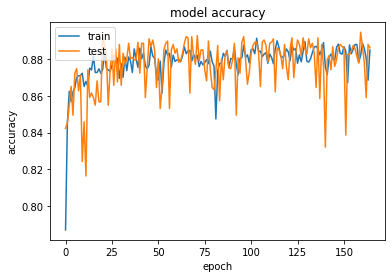

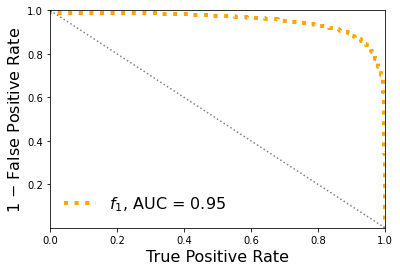

Classification score:


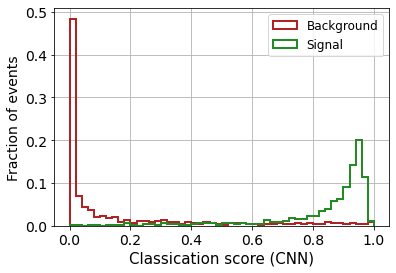


 ROC-AUC =  0.9519782857208674


In [61]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(8, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(8, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [62]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9519782857208674


Epoch 1/500
40/40 [==============================] - 5s 115ms/step - loss: 0.7192 - accuracy: 0.7420 - val_loss: 0.5038 - val_accuracy: 0.8464
Epoch 2/500
40/40 [==============================] - 4s 109ms/step - loss: 0.5056 - accuracy: 0.8482 - val_loss: 0.4463 - val_accuracy: 0.8656
Epoch 3/500
40/40 [==============================] - 4s 109ms/step - loss: 0.4547 - accuracy: 0.8605 - val_loss: 0.4398 - val_accuracy: 0.8554
Epoch 4/500
40/40 [==============================] - 4s 109ms/step - loss: 0.4501 - accuracy: 0.8619 - val_loss: 0.4545 - val_accuracy: 0.8428
Epoch 5/500
40/40 [==============================] - 4s 108ms/step - loss: 0.4535 - accuracy: 0.8486 - val_loss: 0.4159 - val_accuracy: 0.8614
Epoch 6/500
40/40 [==============================] - 4s 109ms/step - loss: 0.4148 - accuracy: 0.8635 - val_loss: 0.4030 - val_accuracy: 0.8566
Epoch 7/500
40/40 [==============================] - 4s 109ms/step - loss: 0.4151 - accuracy: 0.8587 - val_loss: 0.4078 - val_accuracy: 0.8482

Epoch 58/500
40/40 [==============================] - 4s 108ms/step - loss: 0.3410 - accuracy: 0.8789 - val_loss: 0.3424 - val_accuracy: 0.8818
Epoch 59/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3335 - accuracy: 0.8880 - val_loss: 0.3698 - val_accuracy: 0.8716
Epoch 60/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3538 - accuracy: 0.8767 - val_loss: 0.3239 - val_accuracy: 0.8872
Epoch 61/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3355 - accuracy: 0.8792 - val_loss: 0.3350 - val_accuracy: 0.8830
Epoch 62/500
40/40 [==============================] - 4s 108ms/step - loss: 0.3169 - accuracy: 0.8912 - val_loss: 0.3295 - val_accuracy: 0.8908
Epoch 63/500
40/40 [==============================] - 4s 108ms/step - loss: 0.3471 - accuracy: 0.8781 - val_loss: 0.3240 - val_accuracy: 0.8902
Epoch 64/500
40/40 [==============================] - 4s 108ms/step - loss: 0.3202 - accuracy: 0.8848 - val_loss: 0.3185 - val_accuracy:

Epoch 115/500
40/40 [==============================] - 4s 108ms/step - loss: 0.3069 - accuracy: 0.8991 - val_loss: 0.3394 - val_accuracy: 0.8830
Epoch 116/500
40/40 [==============================] - 4s 108ms/step - loss: 0.3240 - accuracy: 0.8883 - val_loss: 0.3170 - val_accuracy: 0.8908
Epoch 117/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3122 - accuracy: 0.8873 - val_loss: 0.3346 - val_accuracy: 0.8914
Epoch 118/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3264 - accuracy: 0.8859 - val_loss: 0.4432 - val_accuracy: 0.8428
Epoch 119/500
40/40 [==============================] - 4s 108ms/step - loss: 0.3597 - accuracy: 0.8677 - val_loss: 0.3168 - val_accuracy: 0.8872
Epoch 120/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3103 - accuracy: 0.8953 - val_loss: 0.3861 - val_accuracy: 0.8602
Epoch 121/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3462 - accuracy: 0.8825 - val_loss: 0.3190 - val_ac

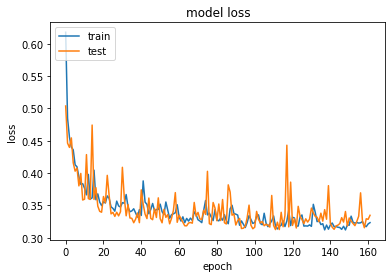

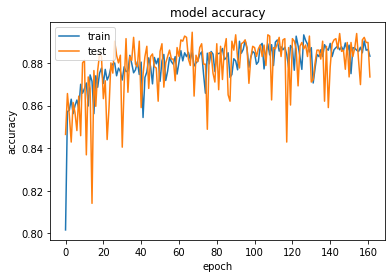

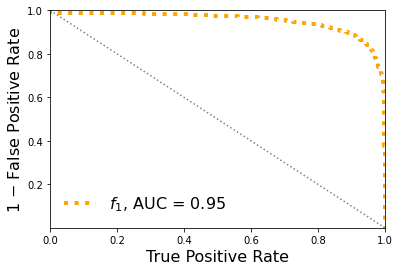

Classification score:


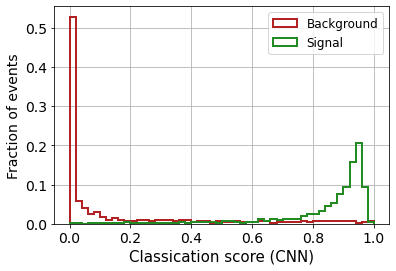


 ROC-AUC =  0.9529508354857565


In [63]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(16, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(16, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [64]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9529508354857565


Epoch 1/500
40/40 [==============================] - 10s 230ms/step - loss: 0.8116 - accuracy: 0.7568 - val_loss: 0.6158 - val_accuracy: 0.8230
Epoch 2/500
40/40 [==============================] - 9s 225ms/step - loss: 0.5822 - accuracy: 0.8415 - val_loss: 0.5235 - val_accuracy: 0.8386
Epoch 3/500
40/40 [==============================] - 9s 223ms/step - loss: 0.4874 - accuracy: 0.8593 - val_loss: 0.4333 - val_accuracy: 0.8710
Epoch 4/500
40/40 [==============================] - 9s 223ms/step - loss: 0.4422 - accuracy: 0.8618 - val_loss: 0.4554 - val_accuracy: 0.8344
Epoch 5/500
40/40 [==============================] - 9s 223ms/step - loss: 0.4358 - accuracy: 0.8589 - val_loss: 0.4031 - val_accuracy: 0.8626
Epoch 6/500
40/40 [==============================] - 9s 223ms/step - loss: 0.4127 - accuracy: 0.8569 - val_loss: 0.5025 - val_accuracy: 0.8038
Epoch 7/500
40/40 [==============================] - 9s 223ms/step - loss: 0.4734 - accuracy: 0.8221 - val_loss: 0.4265 - val_accuracy: 0.847

Epoch 58/500
40/40 [==============================] - 9s 222ms/step - loss: 0.3276 - accuracy: 0.8850 - val_loss: 0.3451 - val_accuracy: 0.8746
Epoch 59/500
40/40 [==============================] - 9s 223ms/step - loss: 0.3277 - accuracy: 0.8810 - val_loss: 0.3288 - val_accuracy: 0.8884
Epoch 60/500
40/40 [==============================] - 9s 223ms/step - loss: 0.3391 - accuracy: 0.8788 - val_loss: 0.3236 - val_accuracy: 0.8884
Epoch 61/500
40/40 [==============================] - 9s 223ms/step - loss: 0.3429 - accuracy: 0.8725 - val_loss: 0.3239 - val_accuracy: 0.8860
Epoch 62/500
40/40 [==============================] - 9s 223ms/step - loss: 0.3198 - accuracy: 0.8897 - val_loss: 0.3270 - val_accuracy: 0.8848
Epoch 63/500
40/40 [==============================] - 9s 222ms/step - loss: 0.3387 - accuracy: 0.8804 - val_loss: 0.3165 - val_accuracy: 0.8842
Epoch 64/500
40/40 [==============================] - 9s 222ms/step - loss: 0.3277 - accuracy: 0.8833 - val_loss: 0.3301 - val_accuracy:

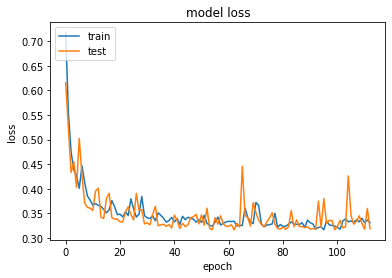

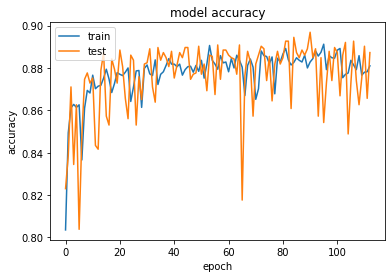

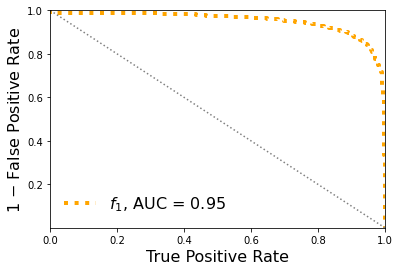

Classification score:


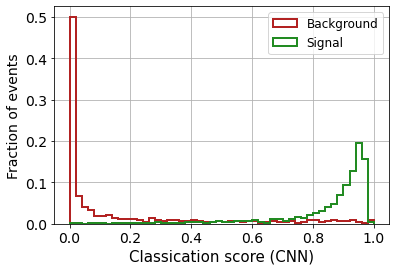


 ROC-AUC =  0.952363778244256


In [65]:

# define the keras model
model = Sequential()
model.add(Conv1D(32, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [66]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.952363778244256


Epoch 1/500
354/354 [==============================] - 1s 989us/step - loss: 64.2715 - accuracy: 0.5058 - val_loss: 0.5343 - val_accuracy: 0.6467
Epoch 2/500
354/354 [==============================] - 0s 550us/step - loss: 2.0359 - accuracy: 0.6486 - val_loss: 0.3795 - val_accuracy: 0.8397
Epoch 3/500
354/354 [==============================] - 0s 514us/step - loss: 0.4181 - accuracy: 0.8194 - val_loss: 0.3124 - val_accuracy: 0.9004
Epoch 4/500
354/354 [==============================] - 0s 516us/step - loss: 0.3395 - accuracy: 0.8652 - val_loss: 0.2254 - val_accuracy: 0.9230
Epoch 5/500
354/354 [==============================] - 0s 524us/step - loss: 0.2665 - accuracy: 0.8985 - val_loss: 0.2032 - val_accuracy: 0.9327
Epoch 6/500
354/354 [==============================] - 0s 507us/step - loss: 0.2520 - accuracy: 0.9021 - val_loss: 0.1965 - val_accuracy: 0.9301
Epoch 7/500
354/354 [==============================] - 0s 512us/step - loss: 0.2396 - accuracy: 0.9089 - val_loss: 0.1884 - val_a

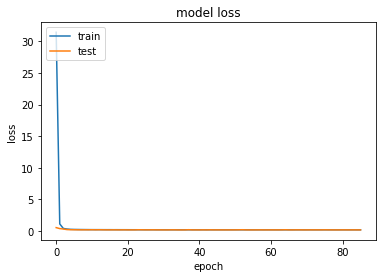

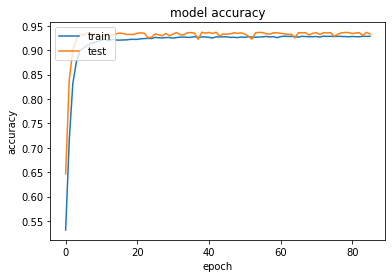

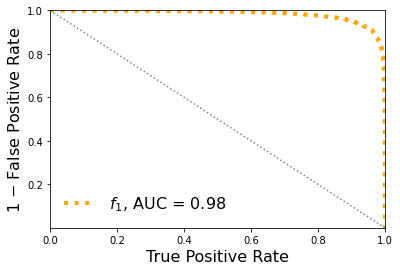

Classification score:


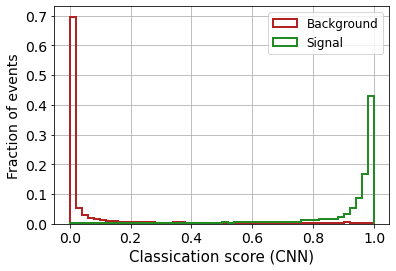


 ROC-AUC =  0.981618453687437


In [47]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
#model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

## 2. only 1 variable: cs2/cs1

In [16]:
# concatenate the data
X_mon_B = np.reshape( (B_cs1cs2[:,1] / B_cs1cs2[:,0]), [len(B_cs1cs2), 1])
X_mon_S = np.reshape( (S_cs1cs2[:,1] / S_cs1cs2[:,0]), [len(S_cs1cs2), 1])

# X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))
# X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))
print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (32117, 1)
X_mon_S.shape:  (32117, 1)
X_mon.shape:  (64234, 1)

X_mon_train :  (40948, 1)
y_mon_train :  (40948,)
X_mon_val :  (7227, 1)
y_mon_val :  (7227,)
X_mon_test :  (16059, 1)
y_mon_test :  (16059,)



## CLASSIFIERS

### XGBoost

[0]	validation_0-logloss:0.69071	validation_1-logloss:0.69071
[1]	validation_0-logloss:0.68834	validation_1-logloss:0.68833


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-logloss:0.68601	validation_1-logloss:0.68599
[3]	validation_0-logloss:0.68373	validation_1-logloss:0.68369
[4]	validation_0-logloss:0.68149	validation_1-logloss:0.68145
[5]	validation_0-logloss:0.67928	validation_1-logloss:0.67924
[6]	validation_0-logloss:0.67713	validation_1-logloss:0.67709
[7]	validation_0-logloss:0.67502	validation_1-logloss:0.67497
[8]	validation_0-logloss:0.67294	validation_1-logloss:0.67289
[9]	validation_0-logloss:0.67090	validation_1-logloss:0.67087
[10]	validation_0-logloss:0.66891	validation_1-logloss:0.66888
[11]	validation_0-logloss:0.66695	validation_1-logloss:0.66692
[12]	validation_0-logloss:0.66503	validation_1-logloss:0.66500
[13]	validation_0-logloss:0.66314	validation_1-logloss:0.66312
[14]	validation_0-logloss:0.66129	validation_1-logloss:0.66127
[15]	validation_0-logloss:0.65946	validation_1-logloss:0.65946
[16]	validation_0-logloss:0.65768	validation_1-logloss:0.65767
[17]	validation_0-logloss:0.65594	validation_1-logloss:0.65593


[260]	validation_0-logloss:0.55209	validation_1-logloss:0.55491
[261]	validation_0-logloss:0.55204	validation_1-logloss:0.55488
[262]	validation_0-logloss:0.55200	validation_1-logloss:0.55485
[263]	validation_0-logloss:0.55195	validation_1-logloss:0.55482
[264]	validation_0-logloss:0.55191	validation_1-logloss:0.55478
[265]	validation_0-logloss:0.55187	validation_1-logloss:0.55475
[266]	validation_0-logloss:0.55182	validation_1-logloss:0.55472
[267]	validation_0-logloss:0.55178	validation_1-logloss:0.55469
[268]	validation_0-logloss:0.55174	validation_1-logloss:0.55466
[269]	validation_0-logloss:0.55170	validation_1-logloss:0.55463
[270]	validation_0-logloss:0.55166	validation_1-logloss:0.55460
[271]	validation_0-logloss:0.55162	validation_1-logloss:0.55457
[272]	validation_0-logloss:0.55158	validation_1-logloss:0.55454
[273]	validation_0-logloss:0.55154	validation_1-logloss:0.55452
[274]	validation_0-logloss:0.55150	validation_1-logloss:0.55450
[275]	validation_0-logloss:0.55146	valid

[389]	validation_0-logloss:0.54869	validation_1-logloss:0.55336
[390]	validation_0-logloss:0.54867	validation_1-logloss:0.55337
[391]	validation_0-logloss:0.54866	validation_1-logloss:0.55337
[392]	validation_0-logloss:0.54864	validation_1-logloss:0.55337
[393]	validation_0-logloss:0.54863	validation_1-logloss:0.55337
[394]	validation_0-logloss:0.54861	validation_1-logloss:0.55337
[395]	validation_0-logloss:0.54860	validation_1-logloss:0.55336
[396]	validation_0-logloss:0.54858	validation_1-logloss:0.55336
[397]	validation_0-logloss:0.54857	validation_1-logloss:0.55336
[398]	validation_0-logloss:0.54856	validation_1-logloss:0.55336
[399]	validation_0-logloss:0.54854	validation_1-logloss:0.55335
[400]	validation_0-logloss:0.54853	validation_1-logloss:0.55335
[401]	validation_0-logloss:0.54851	validation_1-logloss:0.55335
[402]	validation_0-logloss:0.54850	validation_1-logloss:0.55335
[403]	validation_0-logloss:0.54848	validation_1-logloss:0.55334
[404]	validation_0-logloss:0.54846	valid

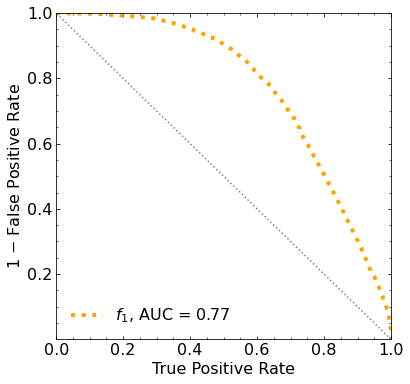

Classification score:


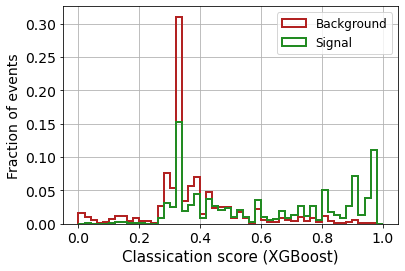


 ROC-AUC =  0.7697915540186094


In [17]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=2500,
    learning_rate=0.01,
    reg_lambda=0.01,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [18]:
np.savetxt('rocs/roc_cs1cs2ratio.txt', [tpr_mon_xg, fpr_mon_xg])

print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.7697915540186094


### DNN

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 128)               256       
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 32)               

320/320 [==============================] - 2s 5ms/step - loss: 0.5737 - accuracy: 0.7029 - val_loss: 0.5605 - val_accuracy: 0.7094
Epoch 39/500
320/320 [==============================] - 1s 3ms/step - loss: 0.5715 - accuracy: 0.7025 - val_loss: 0.5572 - val_accuracy: 0.7116
Epoch 40/500
320/320 [==============================] - 2s 5ms/step - loss: 0.5741 - accuracy: 0.6983 - val_loss: 0.5603 - val_accuracy: 0.7119
Epoch 41/500
320/320 [==============================] - 1s 3ms/step - loss: 0.5733 - accuracy: 0.6995 - val_loss: 0.5597 - val_accuracy: 0.7118
Epoch 42/500
320/320 [==============================] - 1s 5ms/step - loss: 0.5723 - accuracy: 0.7012 - val_loss: 0.5638 - val_accuracy: 0.6917
Epoch 43/500
320/320 [==============================] - 2s 5ms/step - loss: 0.5721 - accuracy: 0.6999 - val_loss: 0.5607 - val_accuracy: 0.7119
Epoch 44/500
320/320 [==============================] - 2s 5ms/step - loss: 0.5714 - accuracy: 0.6976 - val_loss: 0.5589 - val_accuracy: 0.7121
Epoch

Epoch 95/500
320/320 [==============================] - 0s 929us/step - loss: 0.5749 - accuracy: 0.7007 - val_loss: 0.5566 - val_accuracy: 0.7114
Epoch 96/500
320/320 [==============================] - 0s 933us/step - loss: 0.5684 - accuracy: 0.7052 - val_loss: 0.5546 - val_accuracy: 0.7121
Epoch 97/500
320/320 [==============================] - 0s 936us/step - loss: 0.5680 - accuracy: 0.7075 - val_loss: 0.5584 - val_accuracy: 0.7126
Epoch 98/500
320/320 [==============================] - 0s 936us/step - loss: 0.5693 - accuracy: 0.7033 - val_loss: 0.5598 - val_accuracy: 0.7104
Epoch 99/500
320/320 [==============================] - 0s 921us/step - loss: 0.5680 - accuracy: 0.7024 - val_loss: 0.5567 - val_accuracy: 0.7119
Epoch 100/500
320/320 [==============================] - 0s 927us/step - loss: 0.5711 - accuracy: 0.7034 - val_loss: 0.5564 - val_accuracy: 0.7121
Epoch 101/500
320/320 [==============================] - 0s 945us/step - loss: 0.5715 - accuracy: 0.7006 - val_loss: 0.5555

Epoch 151/500
320/320 [==============================] - 0s 935us/step - loss: 0.5679 - accuracy: 0.7067 - val_loss: 0.5553 - val_accuracy: 0.7101
Epoch 152/500
320/320 [==============================] - 0s 940us/step - loss: 0.5699 - accuracy: 0.7035 - val_loss: 0.5548 - val_accuracy: 0.7119
Epoch 153/500
320/320 [==============================] - 0s 936us/step - loss: 0.5663 - accuracy: 0.7065 - val_loss: 0.5557 - val_accuracy: 0.7043
Epoch 154/500
320/320 [==============================] - 0s 933us/step - loss: 0.5688 - accuracy: 0.7039 - val_loss: 0.5564 - val_accuracy: 0.7118
Epoch 155/500
320/320 [==============================] - 0s 928us/step - loss: 0.5685 - accuracy: 0.7037 - val_loss: 0.5541 - val_accuracy: 0.7119
Epoch 156/500
320/320 [==============================] - 0s 947us/step - loss: 0.5631 - accuracy: 0.7087 - val_loss: 0.5569 - val_accuracy: 0.7103
Epoch 157/500
320/320 [==============================] - 0s 943us/step - loss: 0.5678 - accuracy: 0.7063 - val_loss: 0

Epoch 207/500
320/320 [==============================] - 0s 932us/step - loss: 0.5706 - accuracy: 0.7043 - val_loss: 0.5545 - val_accuracy: 0.7115
Epoch 208/500
320/320 [==============================] - 0s 933us/step - loss: 0.5687 - accuracy: 0.7049 - val_loss: 0.5548 - val_accuracy: 0.7122
Epoch 209/500
320/320 [==============================] - 0s 931us/step - loss: 0.5668 - accuracy: 0.7057 - val_loss: 0.5551 - val_accuracy: 0.7097
Epoch 210/500
320/320 [==============================] - 0s 936us/step - loss: 0.5628 - accuracy: 0.7033 - val_loss: 0.5582 - val_accuracy: 0.7119
Epoch 211/500
320/320 [==============================] - 0s 933us/step - loss: 0.5678 - accuracy: 0.7051 - val_loss: 0.5550 - val_accuracy: 0.7121
Epoch 212/500
320/320 [==============================] - 0s 953us/step - loss: 0.5668 - accuracy: 0.7028 - val_loss: 0.5565 - val_accuracy: 0.7082
Epoch 213/500
320/320 [==============================] - 0s 1ms/step - loss: 0.5653 - accuracy: 0.7046 - val_loss: 0.5

Epoch 263/500
320/320 [==============================] - 0s 959us/step - loss: 0.5717 - accuracy: 0.7013 - val_loss: 0.5564 - val_accuracy: 0.7080
Epoch 264/500
320/320 [==============================] - 0s 960us/step - loss: 0.5672 - accuracy: 0.7046 - val_loss: 0.5549 - val_accuracy: 0.7116
Epoch 265/500
320/320 [==============================] - 0s 956us/step - loss: 0.5650 - accuracy: 0.7095 - val_loss: 0.5534 - val_accuracy: 0.7121
Epoch 266/500
320/320 [==============================] - 0s 976us/step - loss: 0.5679 - accuracy: 0.7057 - val_loss: 0.5555 - val_accuracy: 0.7121
Epoch 267/500
320/320 [==============================] - 0s 996us/step - loss: 0.5679 - accuracy: 0.7024 - val_loss: 0.5541 - val_accuracy: 0.7125
Epoch 268/500
320/320 [==============================] - 0s 1ms/step - loss: 0.5663 - accuracy: 0.7066 - val_loss: 0.5550 - val_accuracy: 0.7123
Epoch 269/500
320/320 [==============================] - 0s 1ms/step - loss: 0.5670 - accuracy: 0.7030 - val_loss: 0.555

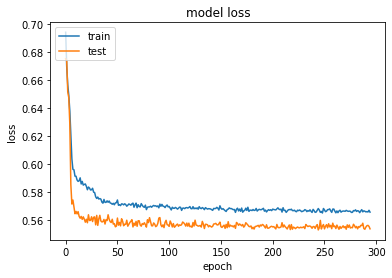

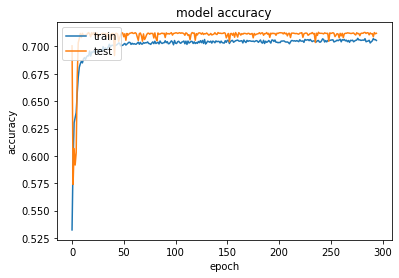

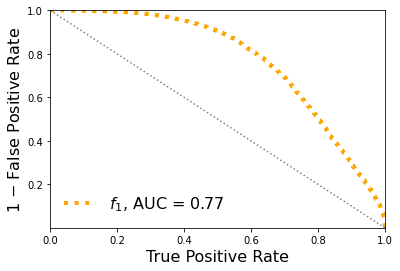

Classification score:


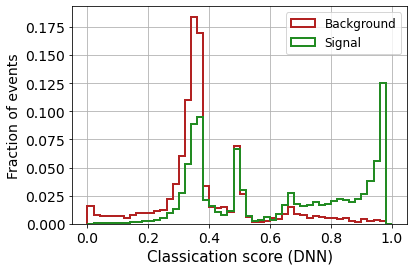


 ROC-AUC =  0.7694733707593221


In [41]:

# define the keras model
model = Sequential()
model.add(Dense(128, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [42]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.7694733707593221
